<a href="https://colab.research.google.com/github/Rohith-Rongali/GridWorld/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google colab

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  os.chdir('/content/drive/MyDrive/Documents/Sem6-drive/RL/Assignments/1Assignment')


Mounted at /content/drive


In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super

# Setup

In [ ]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
NUM_CONFIG = 2000

In [ ]:
from math import floor
import numpy as np
from tqdm import tqdm
import pandas as pd


from functools import partial

from time import sleep
import itertools
from collections import namedtuple

# plotting libraies
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

# !pip install wandb --upgrade
# import wandb
# wandb.login()

# %matplotlib inline

!pip install ipywidgets
!pip install optuna 

import ipywidgets as widgets
from IPython import display
from IPython.display import clear_output


def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [ ]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


# Plotting Helper Functions

In [ ]:
def plot_Q(Q, message = "Q plot"):
    
    # plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(figsize = (10,10))

    Q_max = Q.max(-1)
    im = ax.imshow(Q_max, extent=[0, 10, 0, 10])

    cbar = ax.figure.colorbar(im, ax=ax)
    
    ax.set_title(message)
    #ax.grid(visible = True, which="major", color="w", linestyle='-', linewidth=2)
    ax.set_xlim([0, 10])
    ax.set_ylim([0,10])
    ax.pcolor(Q.max(-1), edgecolors='k', linewidths=1)
    #plt.colorbar()

    # plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return -1 if a == UP else 1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    ax.quiver(idx[1].ravel()+ 0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    fig.tight_layout()
    plt.savefig(f'./plots/{NUM_CONFIG}/b3.png')

In [ ]:
def render_env(env, state, ax = None, render_agent = True, leg = True):
        grid = np.zeros((env.num_rows, env.num_cols))
        for start in env.start_state:
            grid[start[0], start[1]] = 1 # #0066ff blue color
        for goal in env.goal_states:
            grid[goal[0], goal[1]] = 2  #66ff66 - green color
        for obs in env.obs_states:
            grid[obs[0], obs[1]] = 3   #ff3300 - red color
        for bad in env.bad_states:
            grid[bad[0], bad[1]] = 4  #ffff66 - yellow color
        for restart in env.restart_states:
            grid[restart[0], restart[1]] = 5    #ff6600 - orange color
        
        if render_agent:
            grid[state[0], state[1]] = 6 #000000 - black color
        
        
        
        
        # creating legnd with color box
        start_state = mpatches.Patch(color='#0066ff', label='Start')
        goal_state = mpatches.Patch(color='#66ff66', label='Goal')
        obs_state = mpatches.Patch(color='#ff3300', label='Obstructed')
        bad_state = mpatches.Patch(color='#ffff66', label='Bad')
        restart_state = mpatches.Patch(color='#ff6600', label='Restart')
        agent = mpatches.Patch(color='#000000', label='Agent')
        #plt.legend(handles=[start_state, goal_state, obs_state, bad_state, restart_state])
        if render_agent:
            cmap = colors.ListedColormap(['#ffffff', '#0066ff', '#66ff66', '#ff3300', '#ffff66', '#ff6600', '#000000'])
        else:
            cmap = colors.ListedColormap(['#ffffff', '#0066ff', '#66ff66', '#ff3300', '#ffff66', '#ff6600'])

        if ax is None:
            fig, ax = plt.subplots()
            fig.set_size_inches(10,10)
        
        if leg:
            ax.legend(bbox_to_anchor = (1.15, 1), handles=[start_state, goal_state, obs_state, bad_state, restart_state, agent])

        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)
        return ax



def visualize_policy(env, Q, ax = None, plot = True):
  state_seq = env.reset()
  state = seq_to_col_row(state_seq, env.num_rows)[0]

  visited_states = [[state[1], state[0]]]

  done = False
  steps = 0
  total_reward = 0
  while not done:
      
      state_next_seq, reward = env.step(state_seq, Q[state[0], state[1]].argmax())
      state_next = seq_to_col_row(state_next_seq, env.num_rows)[0]

      visited_states.append([state_next[1], state_next[0]])

      state = state_next
      state_seq = row_col_to_seq(np.expand_dims(state, axis = 0), env.num_cols )


      if np.any(np.sum(abs(env.goal_states - np.expand_dims(state_next, axis = 0)), 1)==0): done = True

  
      steps += 1
      total_reward += reward

      if steps == 500:
        done = True
    
  if plot :
    visited_states = np.array(visited_states, dtype = float)
    #visited_states = visited_states + ( np.random.rand(*visited_states.shape) / 3 )
    visited_states += 0.5
    dpath = visited_states[1:] -visited_states[0:-1]
    if ax == None:
      fig, ax = plt.subplots()
      fig.set_size_inches(10, 10)
  
    ax = render_env(env, state = None, ax = ax, render_agent = False, leg = False)
    for start, diff in zip(visited_states, dpath):
      arrow = mpatches.Arrow(*start,  *diff, width = 0.15, color = 'k')
      ax.add_patch(arrow)
    ax.set_title("Steps: %d, Total Reward: %d"%(steps, total_reward))
  return total_reward, steps, ax
    

    
        

In [ ]:
def plot_greed_variations(alg, policy, b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon):
    config_settings = configurations_l[NUM_CONFIG]
    
    # create environment
    env = create_env(**config_settings._asdict())
    
    rewards_l = []
    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    if policy == 'softmax':
        betas_full_list = [b_beta] + l_beta
        choose_action = choose_action_softmax
        for beta in betas_full_list:
            if alg == 'sarsa':
                Q, rewards, steps, env = sarsa(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = b_epsilon, beta = beta, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
                rewards_l.append(rewards)
            else:
                Q, rewards, steps, env = q_learning(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = b_epsilon, beta = beta, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
                rewards_l.append(rewards)
    else:
        epsilons_full_list = [b_epsilon] + l_epsilon
        choose_action = choose_action_epsilon
        for epsilon in epsilons_full_list:
            if alg == 'sarsa':
                Q, rewards, steps, env = sarsa(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = epsilon, beta = b_beta, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
                rewards_l.append(rewards)
            else:
                Q, rewards, steps, env = q_learning(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = epsilon, beta = b_beta, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
                rewards_l.append(rewards)

    for k, rewards in enumerate(rewards_l):
        i, j = (k//2), (k%2)
        
        if policy == 'softmax':
            parameter = r'$\beta$'
            # parameter = 'beta'
            full_list = betas_full_list
        else:
            parameter = r'$\epsilon$'
            # parameter = 'epsilon'
            full_list = epsilons_full_list
        axes = reward_curve(rewards, ax[i,j], label = fr'{parameter} = {full_list[k]}', xy_labels = False)
        axes.legend(loc = 'lower right', prop = {'weight':'bold'})
        
        #axes.set_title(f'{alg}-{policy}-  ' + r'parameter' + f'={full_list[k]}  gamma={b_gamma}  alpha={b_alpha}')
    a_parameter = r'$\alpha$'
    b_parameter = r'$\gamma$'
    # a_parameter = 'alpha'
    # b_parameter = 'gamma'
    fig.suptitle(fr'C-{NUM_CONFIG}-{alg}-{policy} {b_parameter} = {b_gamma}  {a_parameter} = {b_alpha}', weight = 'bold')
    fig.text(0.5, 0.06, 'Episodes', ha='center')
    fig.text(0.05, 0.5, 'Rewards', va='center', rotation='vertical')

    plt.savefig(f'./plots/{NUM_CONFIG}/greed_variations_{alg}_{policy}.png')

def plot_lr_variations(alg, policy, b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon):
    config_settings = configurations_l[NUM_CONFIG]
    
    # create environment
    env = create_env(**config_settings._asdict())
    
    rewards_l = []
    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    if policy == 'softmax':
        choose_action = choose_action_softmax
    else :
        choose_action = choose_action_epsilon
    
    lr_full_list = [b_alpha] + l_alpha
    for alpha in lr_full_list:
        if alg == 'sarsa':
            Q, rewards, steps, env = sarsa(env,  episodes =2000, alpha0 = alpha,  epsilon0 = b_epsilon, beta = b_beta, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
            rewards_l.append(rewards)
        else:
            Q, rewards, steps, env = q_learning(env,  episodes =2000, alpha0 = alpha,  epsilon0 = b_epsilon, beta = b_beta, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
            rewards_l.append(rewards)
    
    full_list = lr_full_list
    parameter = r'$\alpha$'
    a_parameter = r'$\gamma$'
    # parameter = 'alpha'
    # a_parameter = 'gamma'
    for k, rewards in enumerate(rewards_l):
        i, j = (k//2), (k%2)
        
        if policy == 'softmax':
            p_parameter = r'$\beta$'
            # p_parameter = 'beta'
            b_parameter = b_beta
        else:
            p_parameter = r'$/\epsilon$'
            # p_parameter = 'epsilon'
            b_parameter = b_epsilon
        axes = reward_curve(rewards, ax[i,j], label = fr'{parameter} = {full_list[k]}', xy_labels = False)
        axes.legend(loc = 'lower right', prop = {'weight':'bold'})
        
        #axes.set_title(f'{alg}-{policy}-  ' + r'parameter' + f'={full_list[k]}  gamma={b_gamma}  alpha={b_alpha}')
    
    fig.suptitle(fr'C-{NUM_CONFIG}-{alg}-{policy} {a_parameter} = {b_gamma}  {p_parameter} = {b_parameter}', weight = 'bold')
    fig.text(0.5, 0.06, 'Episodes', ha='center')
    fig.text(0.05, 0.5, 'Rewards', va='center', rotation='vertical')

    plt.savefig(f'./plots/{NUM_CONFIG}/lr_variations_{alg}_{policy}.png')

def plot_gamma_variations(alg, policy, b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon):
    config_settings = configurations_l[NUM_CONFIG]
    
    # create environment
    env = create_env(**config_settings._asdict())
    
    rewards_l = []
    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    if policy == 'softmax':
        choose_action = choose_action_softmax
    else :
        choose_action = choose_action_epsilon
    
    gamma_full_list = [b_gamma] + l_gamma
    for gamma in gamma_full_list:
        if alg == 'sarsa':
            Q, rewards, steps, env = sarsa(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = b_epsilon, beta = b_beta, gamma = gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
            rewards_l.append(rewards)
        else:
            Q, rewards, steps, env = q_learning(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = b_epsilon, beta = b_beta, gamma = gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)
            rewards_l.append(rewards)
    
    full_list = gamma_full_list
    parameter = r'$\gamma$'
    a_parameter = r'$\alpha$'
    # parameter = 'gamma'
    # a_parameter = 'alpha'
    for k, rewards in enumerate(rewards_l):
        i, j = (k//2), (k%2)
        
        if policy == 'softmax':
            p_parameter = r'$\beta$'
            b_parameter = b_beta
        else:
            p_parameter = r'$\epsilon$'
            b_parameter = b_epsilon
        axes = reward_curve(rewards, ax[i,j], label = fr'{parameter} = {full_list[k]}', xy_labels = False)
        axes.legend(loc = 'lower right', prop = {'weight':'bold'})
        
        #axes.set_title(f'{alg}-{policy}-  ' + r'parameter' + f'={full_list[k]}  gamma={b_gamma}  alpha={b_alpha}')
    
    fig.suptitle(fr'C-{NUM_CONFIG}-{alg}-{policy} {a_parameter} = {b_alpha}  {p_parameter} = {b_parameter}', weight = 'bold')
    fig.text(0.5, 0.06, 'Episodes', ha='center')
    fig.text(0.05, 0.5, 'Rewards', va='center', rotation='vertical')

    plt.savefig(f'./plots/{NUM_CONFIG}/gamma_variations_{alg}_{policy}.png')

In [ ]:
def best_plots(algorithm, policy, b_alpha,  b_epsilon, b_beta , b_gamma ):
    # create env
    config_settings = configurations_l[NUM_CONFIG]
    
    # create environment
    env = create_env(**config_settings._asdict())

    # train the agent in env
    if policy == 'softmax':
        choose_action = choose_action_softmax
    else:
        choose_action = choose_action_epsilon
    
    if algorithm == 'sarsa':
        alg = sarsa
    else:
        alg = q_learning
    
    Q, rewards, steps, env = alg(env,  episodes =2000, alpha0 = b_alpha,  epsilon0 = b_epsilon, gamma = b_gamma, plot_heat = False, choose_action = choose_action, wandb_logging = False)


    # draw reward curve
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 14))
    ax1 = reward_curve(rewards, ax1, label = 'Reward Curve', xy_labels = True)
    ax2 = steps_taken(steps, ax2, label = 'Steps Taken', xy_labels = True)
    plt.savefig(f'./plots/{NUM_CONFIG}/b1.png')

    
    # draw Image of grid world with policy for 2 runs
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7, 14))

    _, _, ax1 = visualize_policy(env, Q, ax1, plot = True)
    _, _, ax2 = visualize_policy(env, Q, ax2, plot = True)
    plt.savefig(f'./plots/{NUM_CONFIG}/b2.png')

    # plt.clf()
    plot_Q(Q)
    return Q



In [ ]:
def plot_all(b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon):

    # plot for softmax & sarsa
    # plot for epsilon greedy & softmax
        # plot for epsion / temp
        # plot for learning_rate
        # plot for gamma

    for alg in ['Q-learning', 'sarsa']:
        for policy in ['e-greedy', 'softmax']:
            plot_greed_variations(alg, policy, b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon)
            plot_lr_variations(alg, policy, b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon)
            plot_gamma_variations(alg, policy, b_alpha, l_alpha, b_beta, l_beta, b_gamma, l_gamma, b_epsilon, l_epsilon)

In [ ]:
def reward_curve(episode_rewards, ax = None, label  = None, xy_labels = True):
  if ax == None:
    ax = plt.gca()
  if xy_labels:
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
  ax.plot(np.arange(len(episode_rewards)),episode_rewards, label = label)
  #plt.show()
  return ax

In [ ]:
def steps_taken(episode_steps, ax = None, label  = None, xy_labels = True):
  if ax == None:
    ax = plt.gca()
  if xy_labels:
    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps Taken')
  ax.plot(np.arange(len(episode_steps)),episode_steps, label = label)
  #plt.show()
  return ax

# Algorithms and Helper Functions

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [ ]:

from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[state[0], state[1]])

# Softmax
def choose_action_softmax(Q, state, beta = 1, rg=rg):
    probs = np.nan_to_num(softmax( np.nan_to_num(Q[state[0], state[1]] / beta )))
    probs /= probs.sum()  # normalize
    return rg.choice(Q.shape[-1], p = probs)

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [ ]:


def sarsa(env, episodes = 2000, alpha0 = 0.4,  epsilon0 = 0.1, beta = 1, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax, print_freq = 100, max_steps = 100, wandb_logging = False):
    
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    
    # Adding code to display experiment parameters
    parameters = dict()

    parameters['Algorithm'] = 'Sarsa'
    parameters['episodes'] = episodes
    parameters['policy'] = 'Softmax' if choose_action == choose_action_softmax else 'Epsilon Greedy'
    parameters['gamma'] = gamma
    parameters['epsilon'] = epsilon0
    parameters['alpha'] = alpha0
    

    df = pd.DataFrame(parameters, index=[0])

    # For epsilon greedy
    if choose_action == choose_action_epsilon:
        choose_action = partial( choose_action_epsilon, epsilon = epsilon0)
    if choose_action == choose_action_softmax:
        choose_action = partial( choose_action_softmax, beta = beta)
    

    ########
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state_seq = env.reset()
        state = seq_to_col_row(state_seq, env.num_cols )[0]

        action = choose_action(Q, state)
        done = False
        while not done:
            state_next_seq, reward = env.step(state_seq, action)
            state_next = seq_to_col_row(state_next_seq, env.num_cols)[0]
            action_next = choose_action(Q, state_next)
            
            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1

            if steps == max_steps or np.any(np.sum(abs(env.goal_states - np.expand_dims(state_next, axis = 0)), 1)==0): done = True
            
            state, action = state_next, action_next
            state_seq = row_col_to_seq(np.expand_dims(state, axis = 0), env.num_cols )
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if wandb_logging:
            wandb.log({'Reward': tot_reward, 'Steps': steps})

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
    #print(df)            
    return Q, episode_rewards, steps_to_completion, env

## Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA.

In [ ]:


def q_learning(env, episodes = 2000, alpha0 = 0.4,  epsilon0 = 0.1, beta = 1, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax, print_freq = 100, max_steps = 100, wandb_logging = False):
    
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    
    # Adding code to display experiment parameters
    parameters = dict()

    parameters['Algorithm'] = 'Q-learning'
    parameters['episodes'] = episodes
    parameters['policy'] = 'Softmax' if choose_action == choose_action_softmax else 'Epsilon Greedy'
    parameters['gamma'] = gamma
    parameters['epsilon'] = epsilon0
    parameters['alpha'] = alpha0
    

    df = pd.DataFrame(parameters, index=['Values'])
    
    # For epsilon greedy
    if choose_action == choose_action_epsilon:
        choose_action = partial( choose_action_epsilon, epsilon = epsilon0)
    if choose_action == choose_action_softmax:
        choose_action = partial( choose_action_softmax, beta = beta)

    ########
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state_seq = env.reset()
        state = seq_to_col_row(state_seq, env.num_cols )[0]
        #action = choose_action(Q, state)
        done = False
        while not done:
            action = choose_action(Q, state)

            state_next_seq, reward = env.step(state_seq, action)
            state_next = seq_to_col_row(state_next_seq, env.num_cols)[0]

            action_next = np.argmax(Q[state_next[0], state_next[1]])
            
            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1

            if steps == max_steps or np.any(np.sum(abs(env.goal_states - np.expand_dims(state_next, axis = 0)), 1)==0): done = True
            
            state, action = state_next, action_next
            state_seq = row_col_to_seq(np.expand_dims(state, axis = 0), env.num_cols )
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if wandb_logging:
            wandb.log({'Reward': tot_reward, 'Steps': steps})
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
    #display.display( df.T )  
    return Q, episode_rewards, steps_to_completion, env

# Config Setup

In [ ]:
wind = [True, False]
start_states = np.array([ [[0,4]], [[3,6]] ])
p = [1.0, 0.7, 0.35]

configurations_l = list(itertools.product(wind, start_states, p))

In [ ]:
env_config = namedtuple("env_config", "wind start_state p")
configurations_l = [env_config(wind, start_state, p) for wind, start_state, p in configurations_l]

In [ ]:
configurations_l

[env_config(wind=True, start_state=array([[0, 4]]), p=1.0),
 env_config(wind=True, start_state=array([[0, 4]]), p=0.7),
 env_config(wind=True, start_state=array([[0, 4]]), p=0.35),
 env_config(wind=True, start_state=array([[3, 6]]), p=1.0),
 env_config(wind=True, start_state=array([[3, 6]]), p=0.7),
 env_config(wind=True, start_state=array([[3, 6]]), p=0.35),
 env_config(wind=False, start_state=array([[0, 4]]), p=1.0),
 env_config(wind=False, start_state=array([[0, 4]]), p=0.7),
 env_config(wind=False, start_state=array([[0, 4]]), p=0.35),
 env_config(wind=False, start_state=array([[3, 6]]), p=1.0),
 env_config(wind=False, start_state=array([[3, 6]]), p=0.7),
 env_config(wind=False, start_state=array([[3, 6]]), p=0.35)]

In [ ]:
def create_env(wind, start_state, p):
    # create model
    gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states, wind = wind)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
                
    gw.add_transition_probability(p_good_transition=p,
                                bias=0.5)
    env = gw.create_gridworld()
    return env

In [ ]:
def run(config= None):

    wandb_logging = True # set the global logging to true

    
    config_settings = configurations_l[NUM_CONFIG]
    
    # create environment
    env = create_env(**config_settings._asdict())

    with wandb.init(config=config,  tags = [str(NUM_CONFIG)]):
        if config == None:
            config = wandb.config

        if config.policy == 'softmax':
            choose_action = partial(choose_action_softmax, beta = config.beta)
        else:
            choose_action = partial(choose_action_epsilon, epsilon = config.epsilon)
        
        if config.algorithm == 'sarsa':
            Q, rewards, steps, env = sarsa(env,  episodes =2000, alpha0 = config.alpha,  epsilon0 = config.epsilon, gamma = config.gamma, plot_heat = False, choose_action = choose_action, wandb_logging = True)
        else:
            Q, rewards, steps, env = q_learning(env,  episodes =2000, alpha0 = config.alpha,  epsilon0 = config.epsilon, gamma = config.gamma, plot_heat = False, choose_action = choose_action, wandb_logging = True)
        
        wandb.log({"avg reward(train)": np.average(rewards), "avg steps(train)" : np.average(steps)})

        test_rewards, test_steps = [] , []
        for _ in range(100):
          reward, steps, _ = visualize_policy(env, Q, None, False)
          test_rewards.append(reward)
          test_steps.append(steps)
        wandb.log({"avg reward(test)": np.average(test_rewards), "avg steps(test)" : np.average(test_steps)})

# Experiments

## Visualize Environment

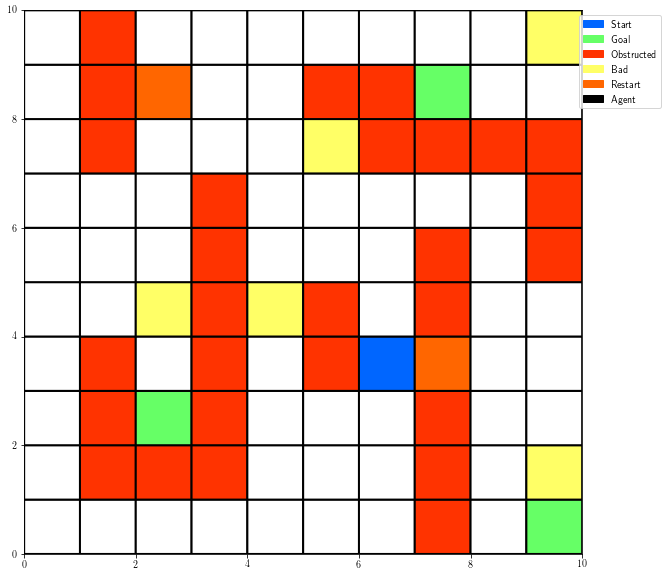

In [ ]:
ax = render_env(env, state=None, render_agent=False)
plt.savefig('./plots/main/env_init.png')
plt.show()

## Configurations

## Config 0

In [ ]:
NUM_CONFIG = 0

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Best HP

In [ ]:
# swwep 19

alpha = 0.1022
l_alpha = [0.08, 0.11, 0.09]
beta = 0.6916
l_beta = [0.5, 0.8, 0.9]
gamma = 0.9364
l_gamma = [0.85, 0.9, 1.0]
epsilon = 0.06584
l_epsilon = [0.1, 0.2, 0.03]
policy = 'e-greedy'
algorithm = 'sarsa'

### Plotting

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [00:08<00:00, 225.82it/s]


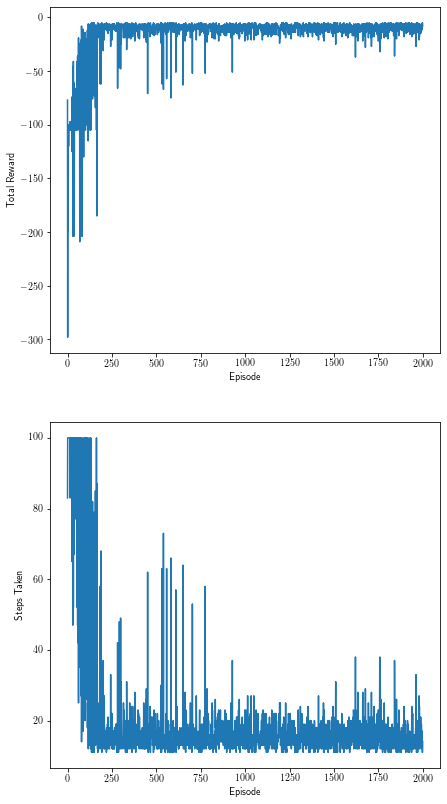

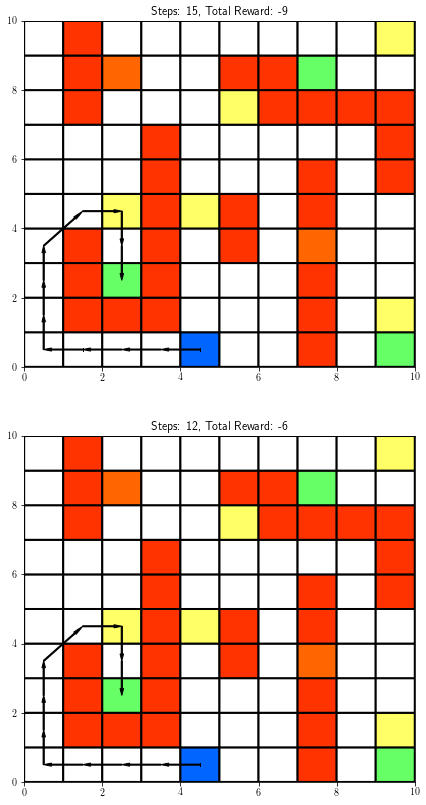

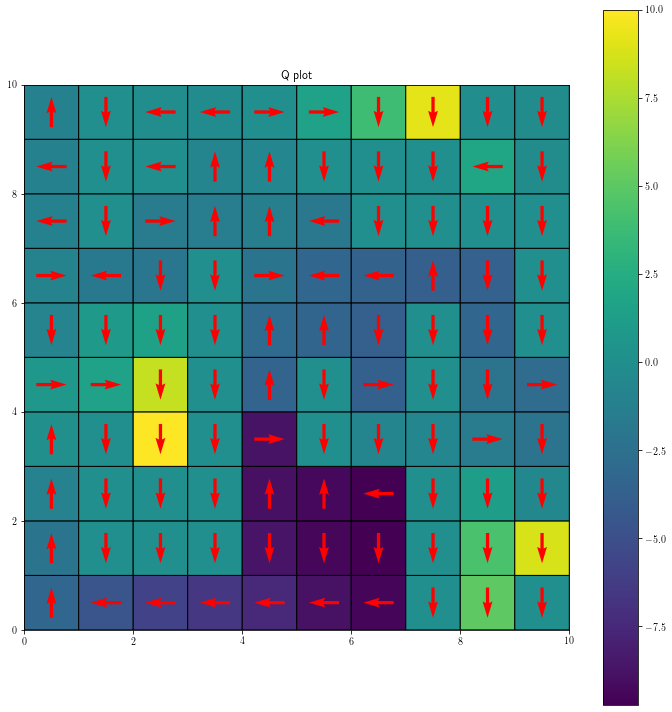

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## Config 1

Setting up a sweep

In [ ]:
NUM_CONFIG = 1

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

### wandb Sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

best configuration

In [ ]:
alpha = 0.1771
l_alpha = [0.20, 0.1, 0.15]
beta = 0.8304
l_beta = [1, 0.8, 0.9]
gamma = 0.9964
l_gamma = [0.95, 0.9, 1.0]
epsilon = 0.05
l_epsilon = [0.1, 0.15, 0.2]
# for epsilon we are using these 4 values only to explore
policy = 'e-greedy'
algorithm = 'sarsa'

Writing functions to automate plots for all the configurations

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

best pltos 

In [ ]:
policy = 'softmax'

100%|██████████| 2000/2000 [00:39<00:00, 50.46it/s]


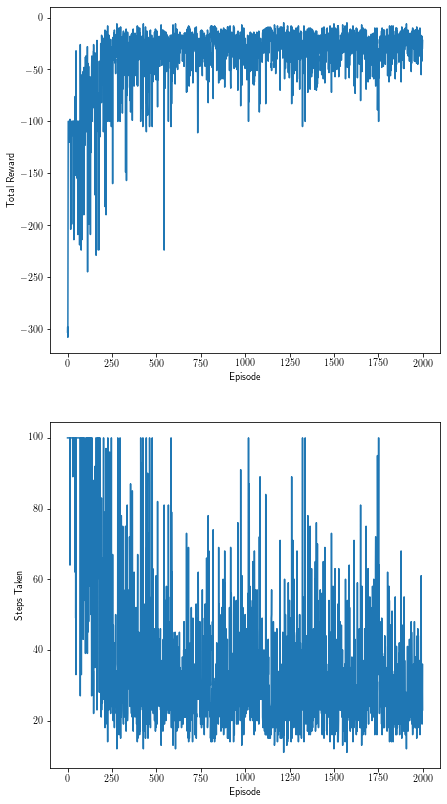

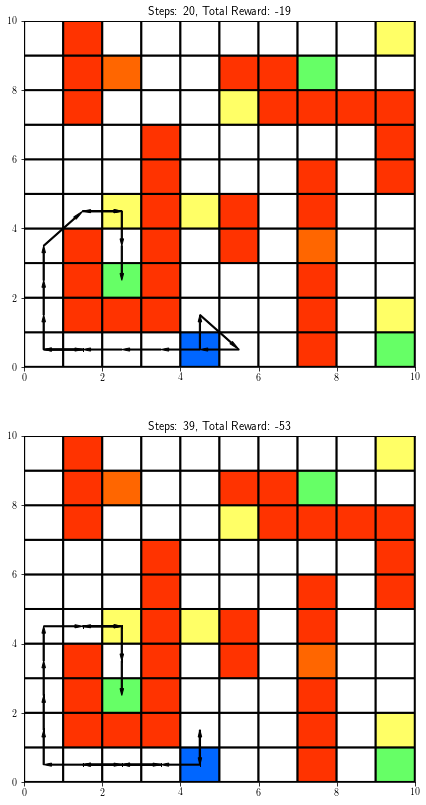

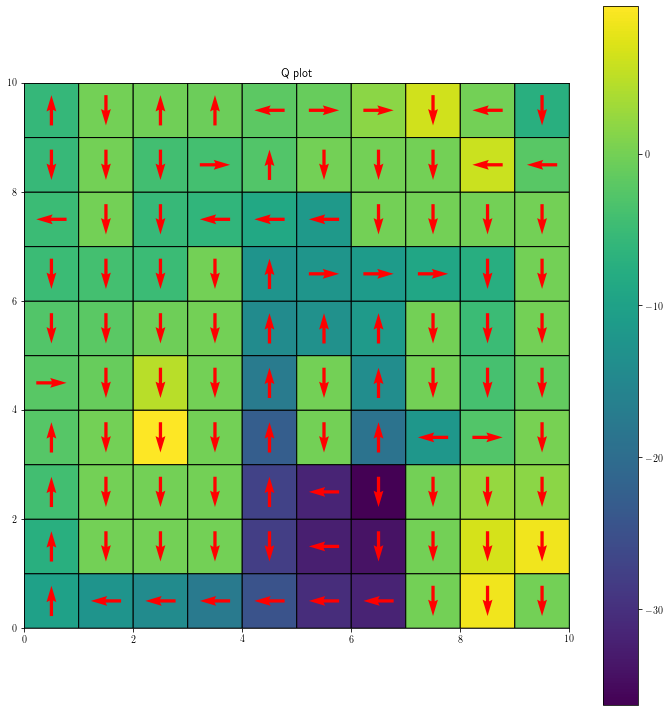

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## Config 2

In [ ]:
NUM_CONFIG = 2

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

### Plotting 

In [ ]:
alpha = 0.1643
l_alpha = [0.20, 0.1, 0.15]
beta = 0.6187
l_beta = [0.5, 0.8, 0.7]
gamma = 0.967
l_gamma = [0.95, 0.9, 1.0]
epsilon = 0.05
l_epsilon = [0.1, 0.15, 0.2]
# for epsilon we are using these 4 values only to explore
policy = 'softmax'
algorithm = 'sarsa'

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [01:37<00:00, 20.44it/s]


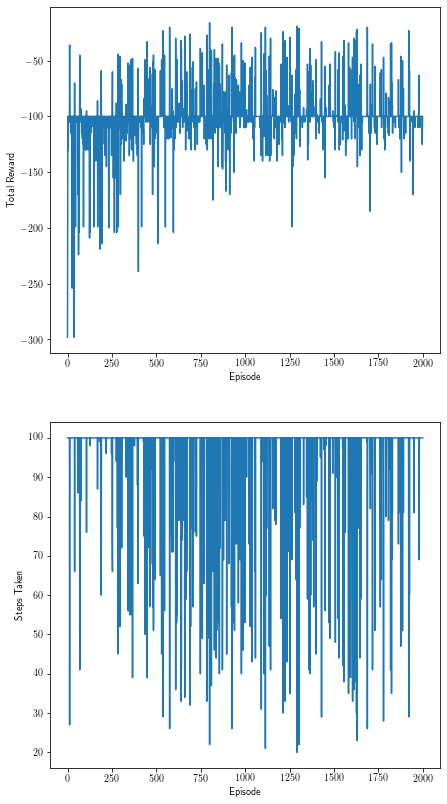

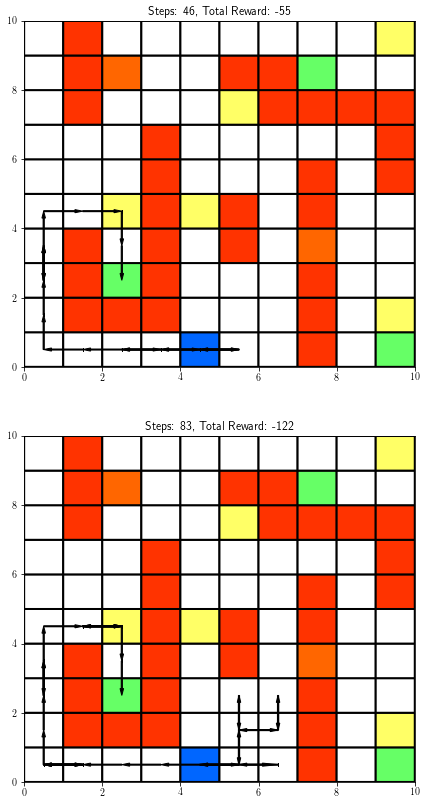

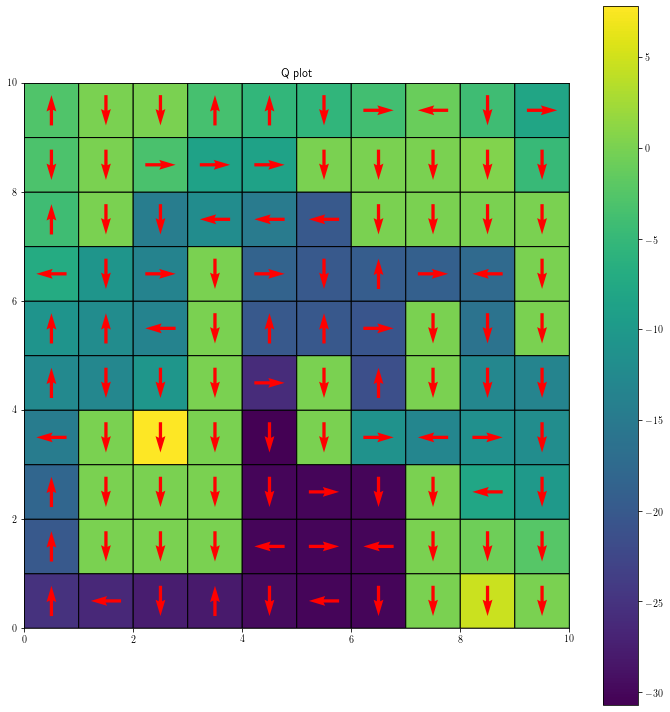

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

### wandb sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

## Config 3

In [ ]:
NUM_CONFIG = 3

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

### wandb sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:
alpha = 0.1181
l_alpha = [0.10, 0.12, 0.15]
beta = 1.442
l_beta = [1.5, 1.3, 1.2]
gamma = 0.5043
l_gamma = [0.6, 0.4, 0.55]
epsilon = 0.06649
l_epsilon = [0.1, 0.05, 0.15]
policy = 'e_greedy'
algorithm = 'q-learning'

In [ ]:
plt.style.use('seaborn')

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [00:10<00:00, 186.33it/s]


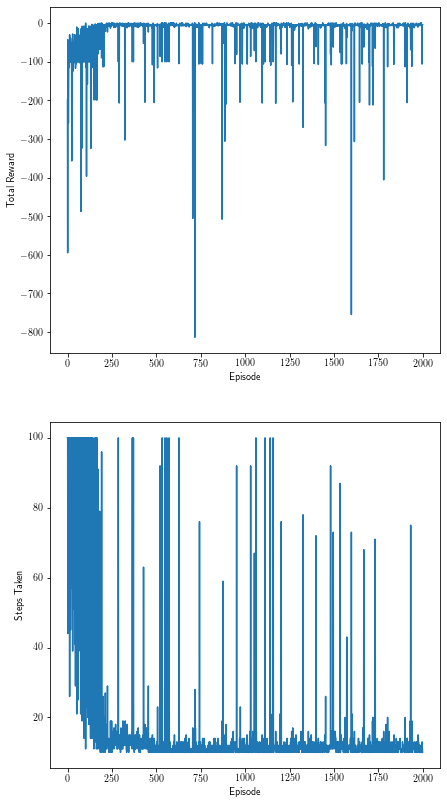

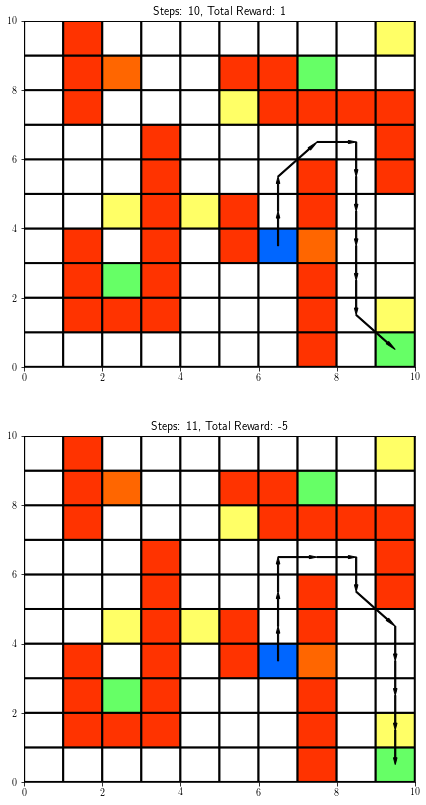

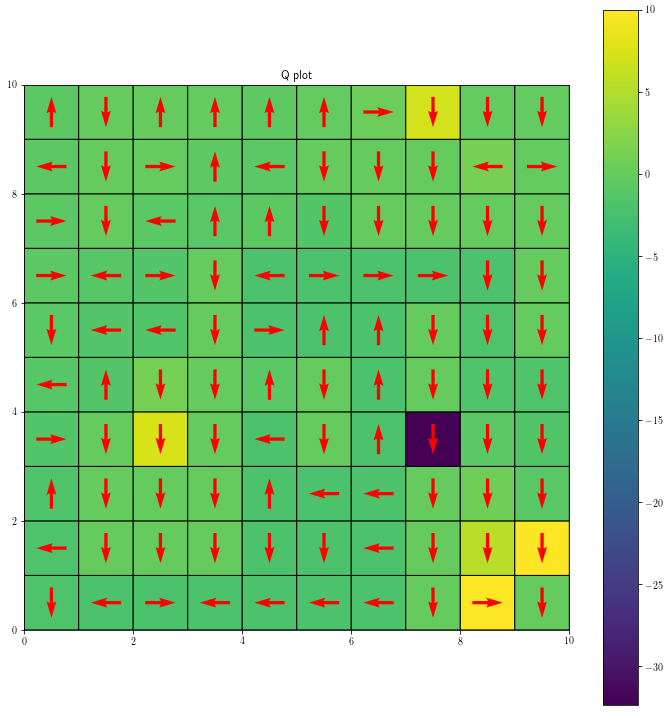

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## config 9


In [ ]:
NUM_CONFIG = 9

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:
alpha = 0.1832
l_alpha = [0.15, 0.12, 0.20]
beta = 0.6001
l_beta = [0.65, 0.7, 0.5]
gamma = 0.976
l_gamma = [0.99, 0.95, 0.90]
epsilon = 0.05
l_epsilon = [0.1, 0.15, 0.2]
policy = 'softmax'
algorithm = 'sarsa'

In [ ]:
plt.style.use('seaborn')

100%|██████████| 2000/2000 [00:17<00:00, 115.12it/s]


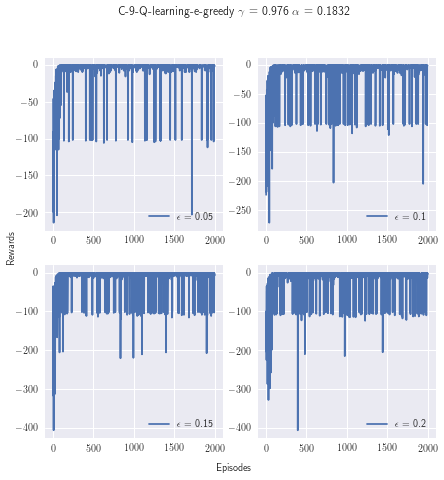

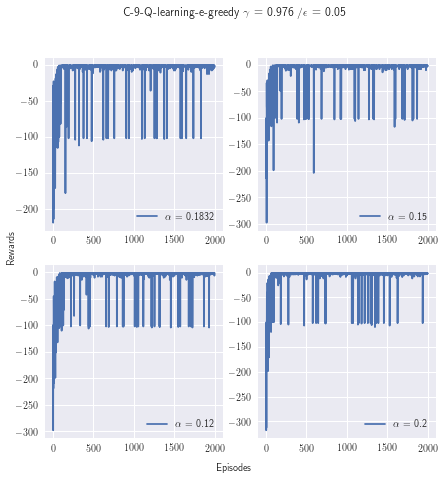

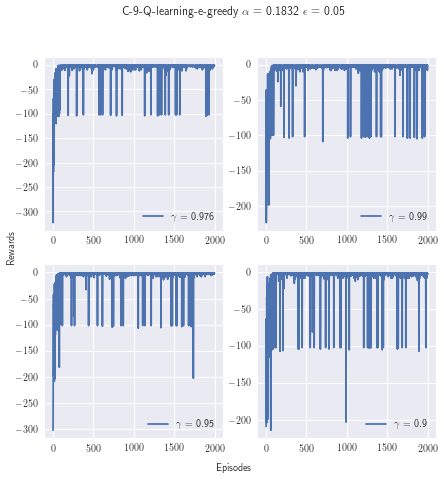

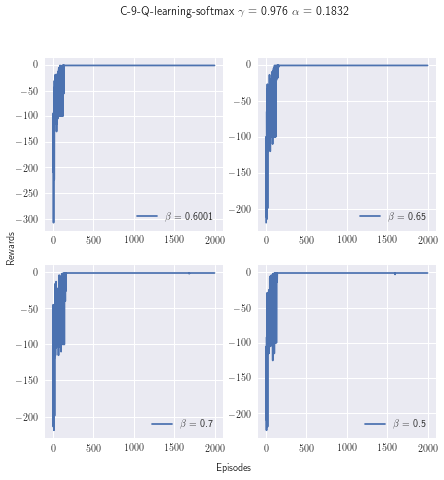

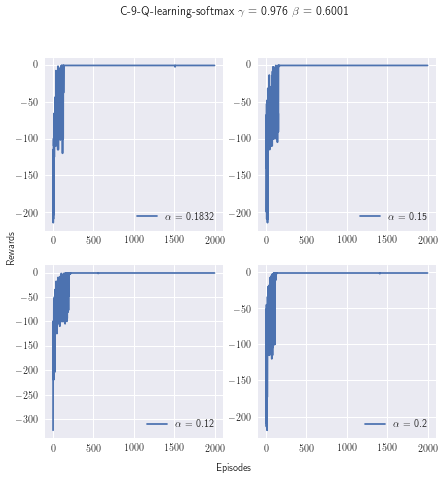

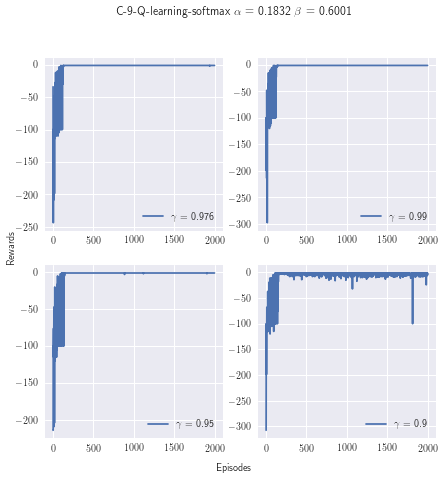

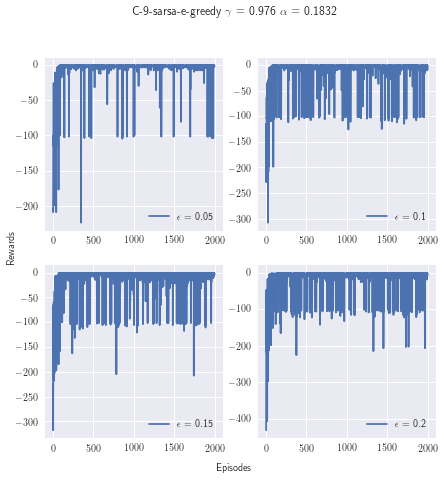

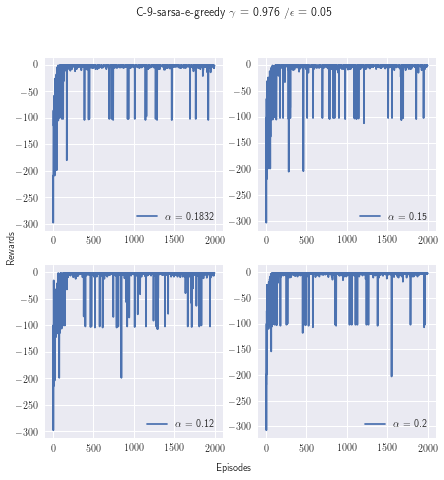

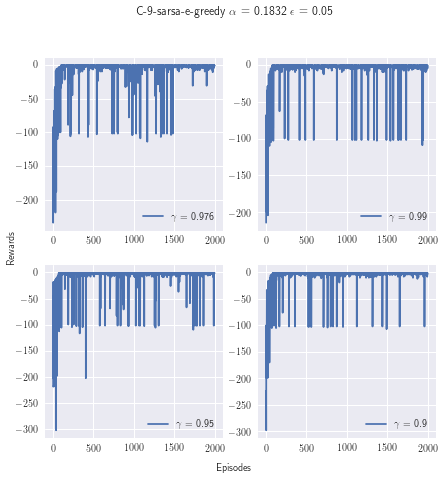

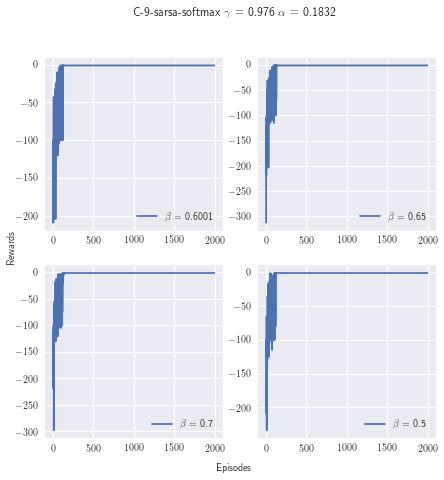

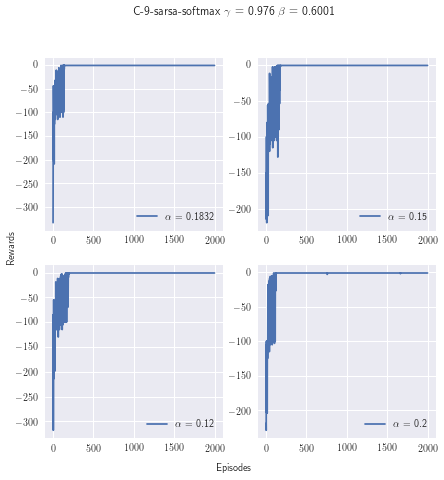

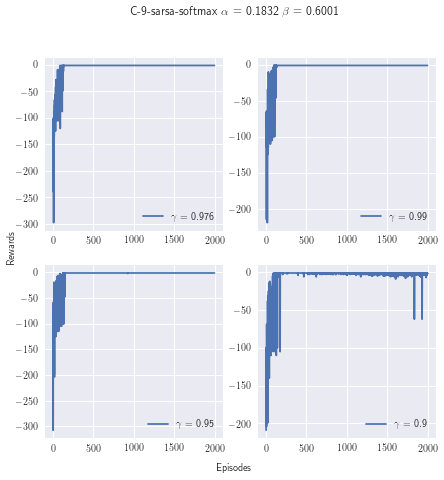

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [00:22<00:00, 87.31it/s]


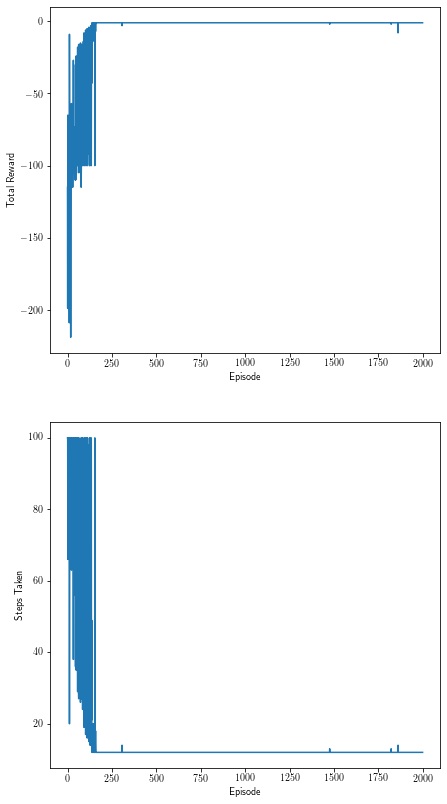

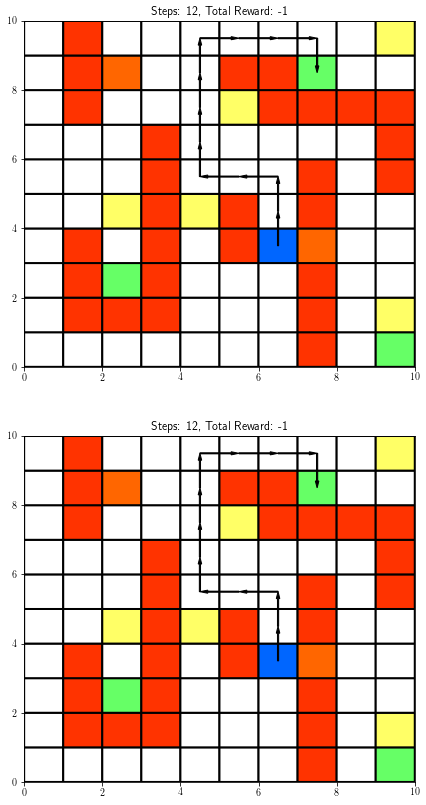

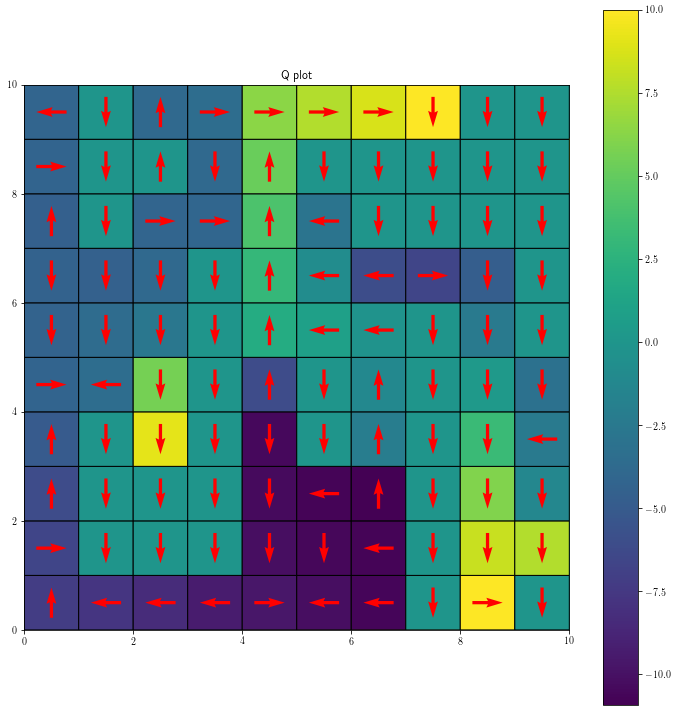

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## config 10

In [ ]:
NUM_CONFIG = 10

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:
alpha = 0.09535
l_alpha = [0.1, 0.15, 0.05]
beta = 1.254
l_beta = [1.1, 1.0, 1.4]
gamma = 0.9549
l_gamma = [0.99, 0.90, 1.0]
epsilon = 0.05
l_epsilon = [0.1, 0.15, 0.2]
policy = 'e-greedy'
algorithm = 'q-learning'

In [ ]:
matplotlib.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [ ]:
plt.style.use('ggplot')

100%|██████████| 2000/2000 [00:36<00:00, 54.52it/s]


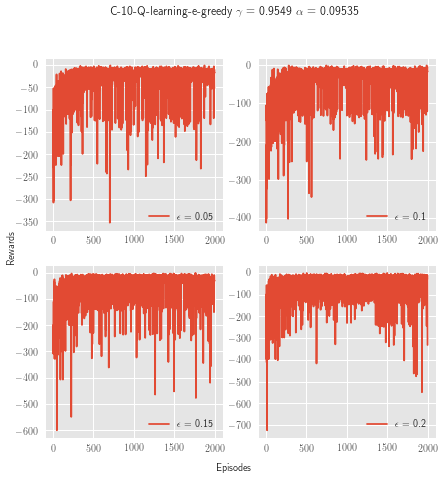

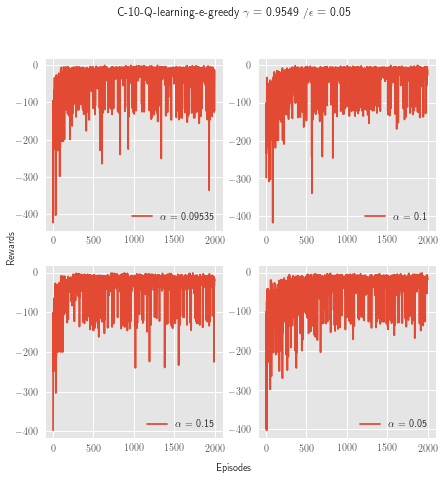

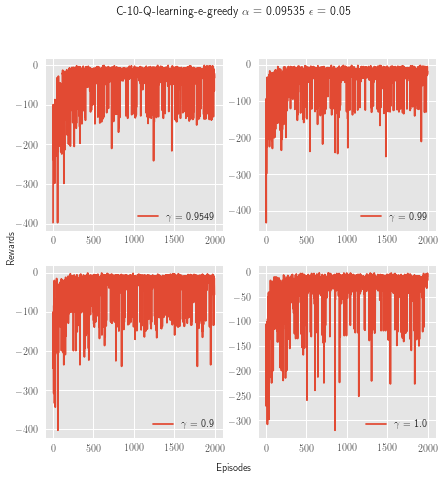

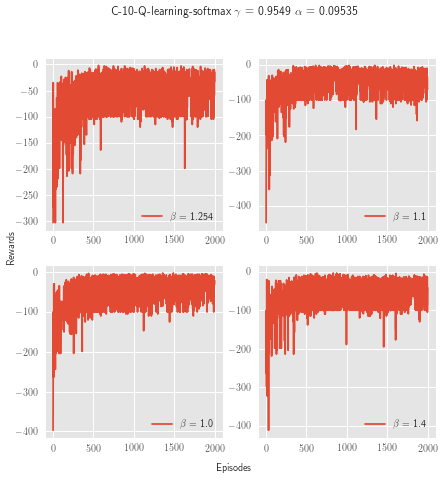

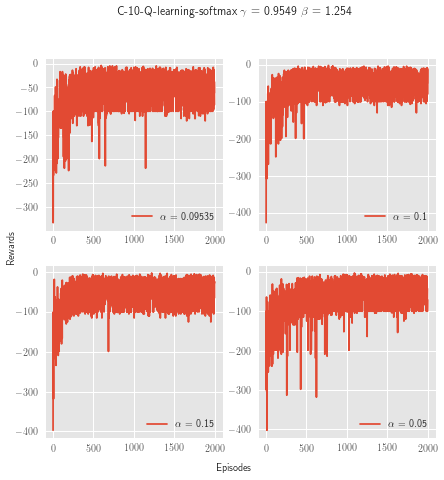

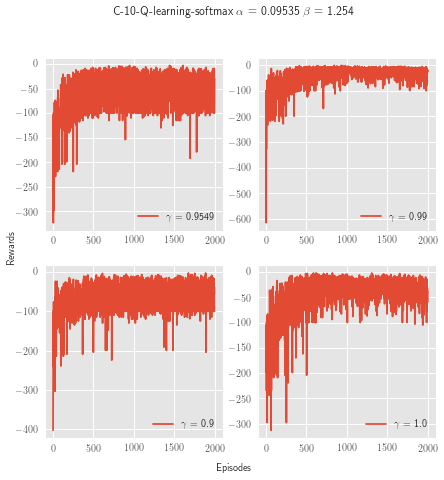

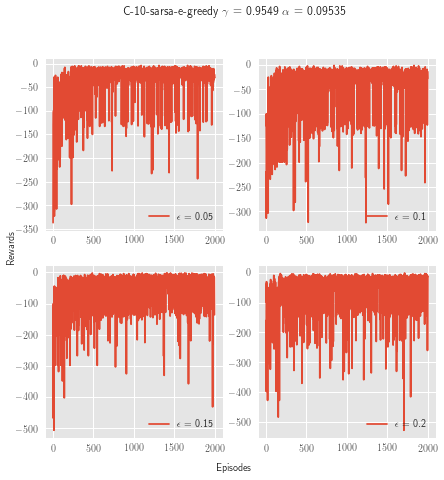

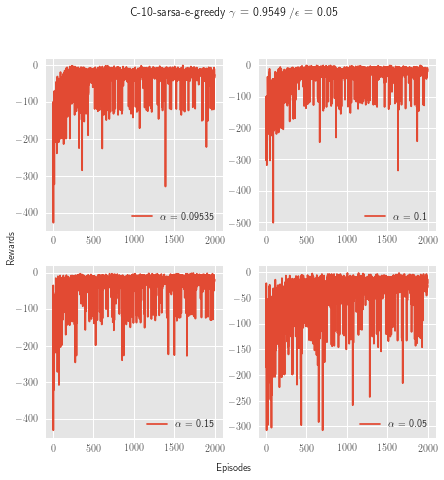

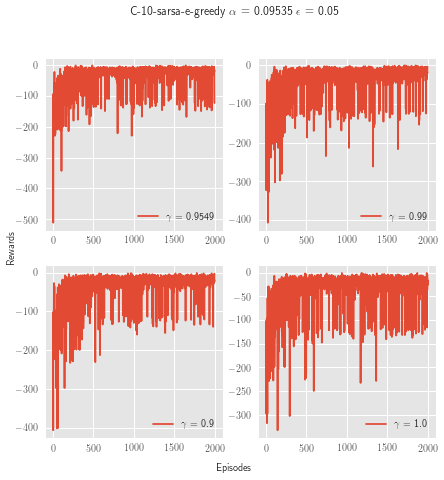

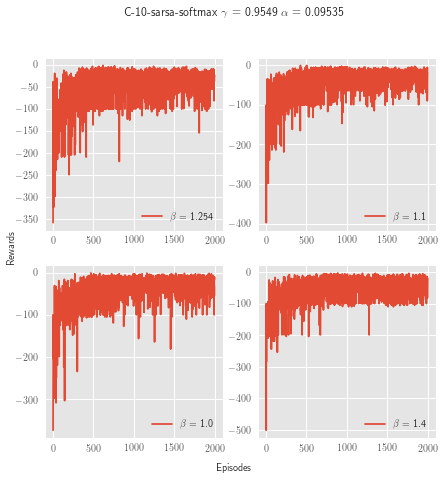

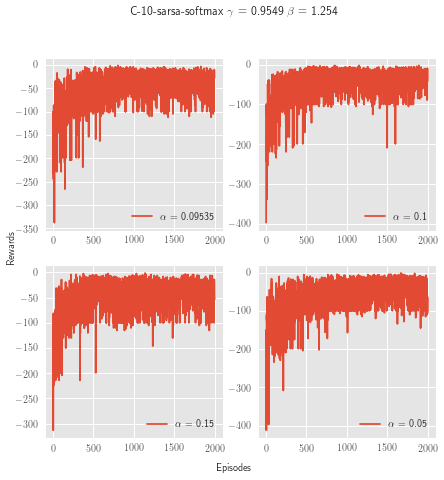

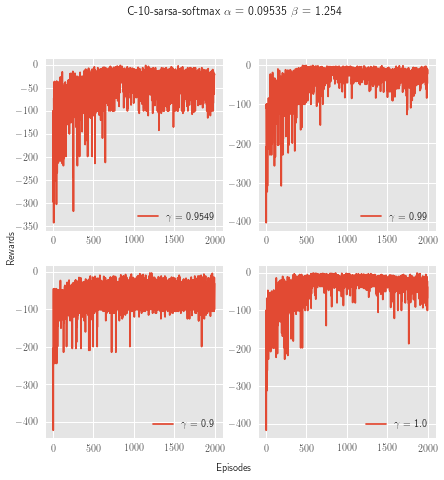

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

In [ ]:
policy = 'softmax'
gamma = 0.99

100%|██████████| 2000/2000 [00:53<00:00, 37.43it/s]


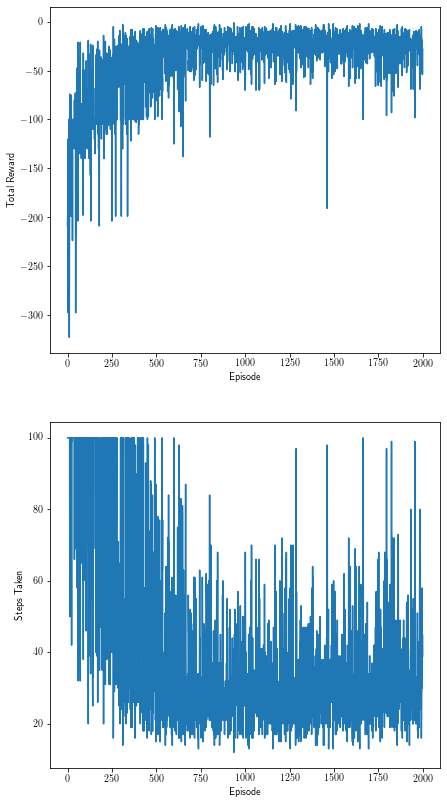

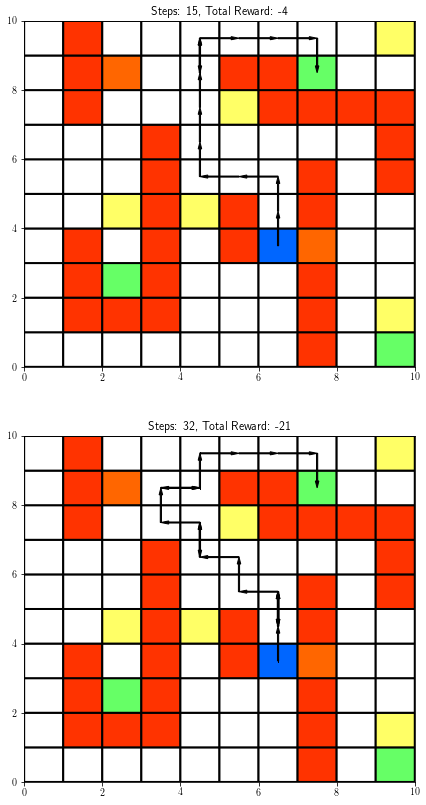

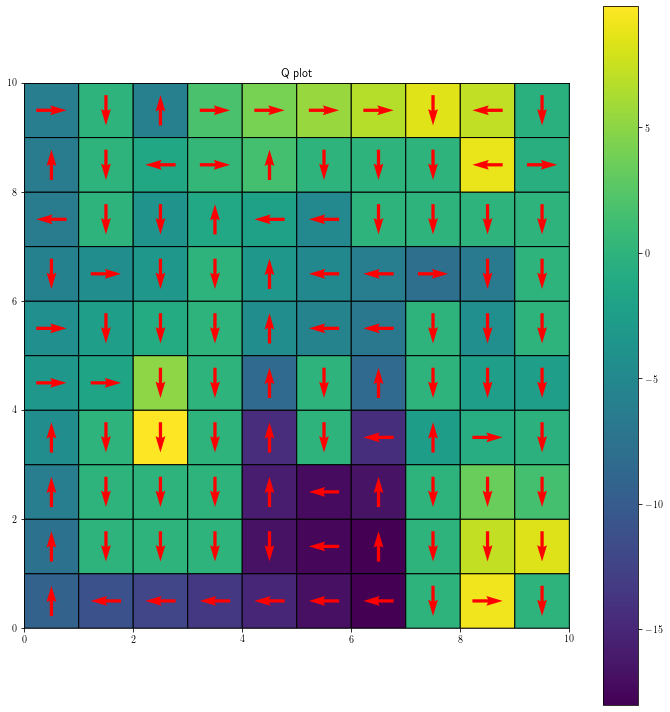

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## Config 4

In [ ]:
NUM_CONFIG = 4

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
          },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

Create sweep with ID: h84lgbi5
Sweep URL: https://wandb.ai/sathvikjoel/RLPA1/sweeps/h84lgbi5


In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:
# swwep 19

alpha = 0.1732
l_alpha = [0.18, 0.15, 0.2]
beta = 0.8155
l_beta = [1, 0.7, 0.9]
gamma = 0.958
l_gamma = [0.85, 0.9, 1.0]
epsilon = 0.09116
l_epsilon = [0.1, 0.05, 0.2]
policy = 'e-greedy'
algorithm = 'sarsa'

In [ ]:
plt.style.use('ggplot')

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [00:19<00:00, 104.49it/s]


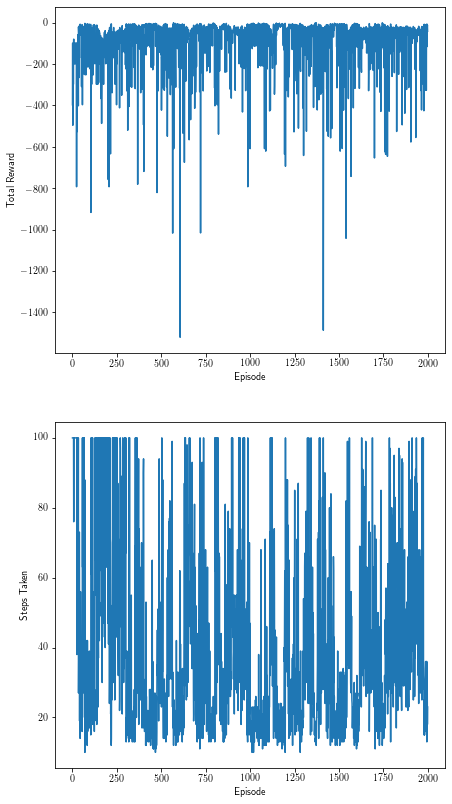

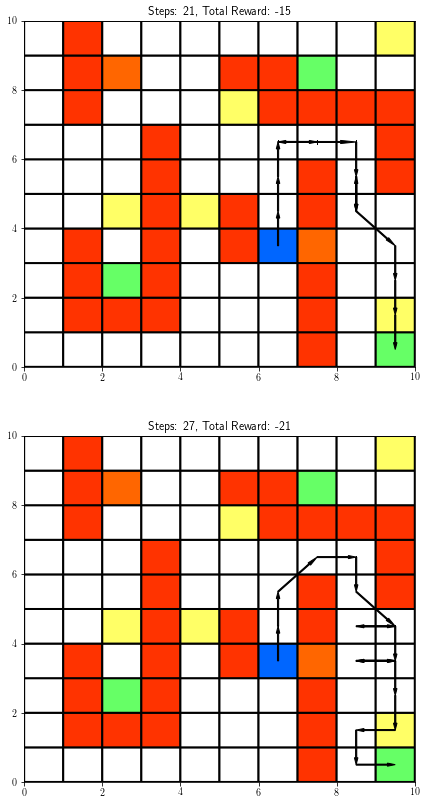

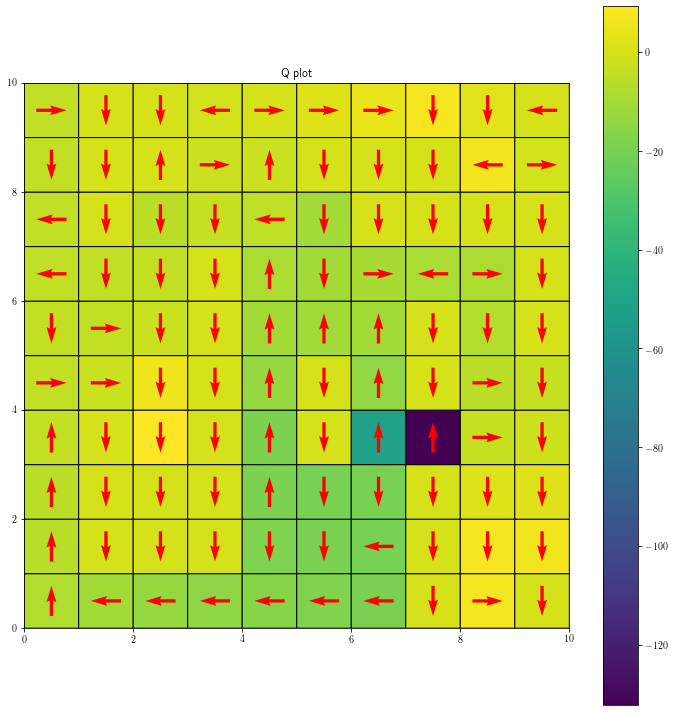

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## Config 5

In [ ]:
NUM_CONFIG = 5

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:
# swwep 19

alpha = 0.02983
l_alpha = [0.1, 0.07, 0.01]
beta = 1.478
l_beta = [1, 1.2, 1.3]
gamma = 0.9685
l_gamma = [0.85, 0.9, 1.0]
epsilon = 0.7722
l_epsilon = [0.5, 0.3, 0.8]
policy = 'softmax'
algorithm = 'q-learning'

In [ ]:
plt.style.use('ggplot')

100%|██████████| 2000/2000 [01:08<00:00, 29.39it/s]


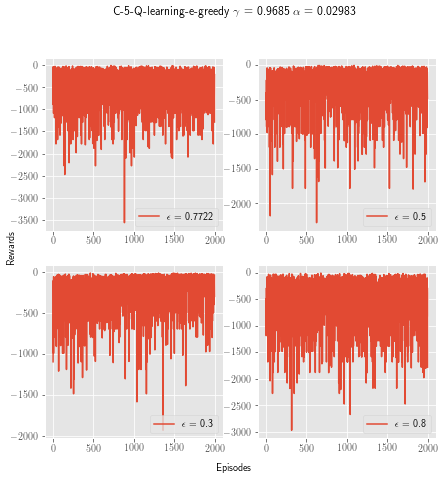

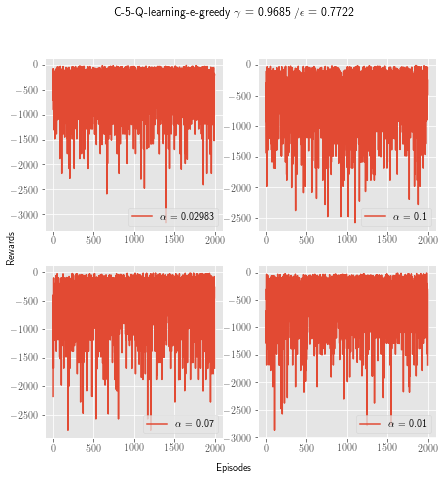

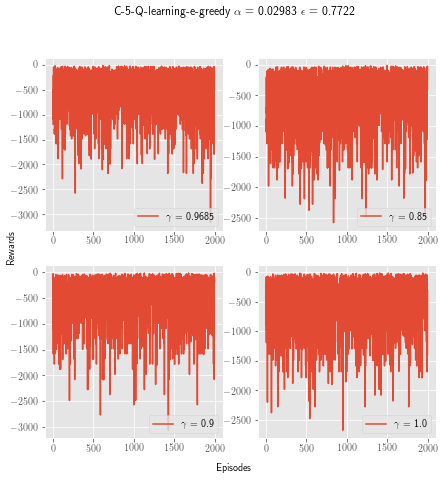

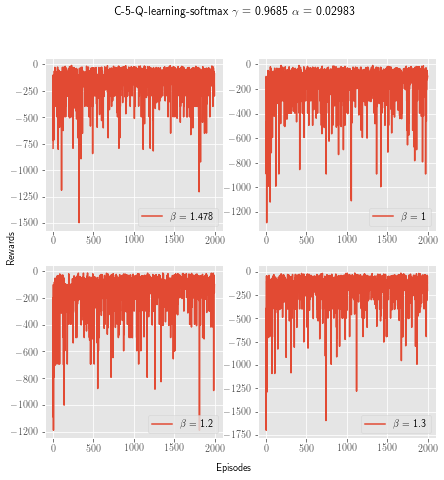

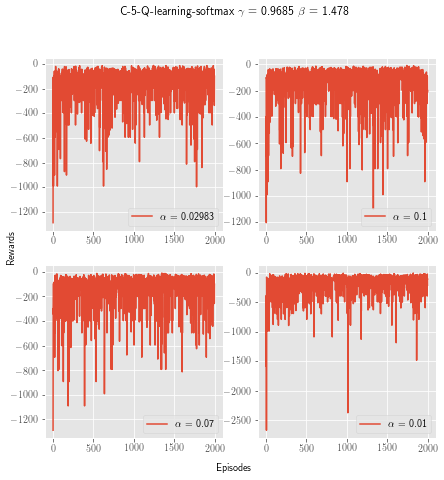

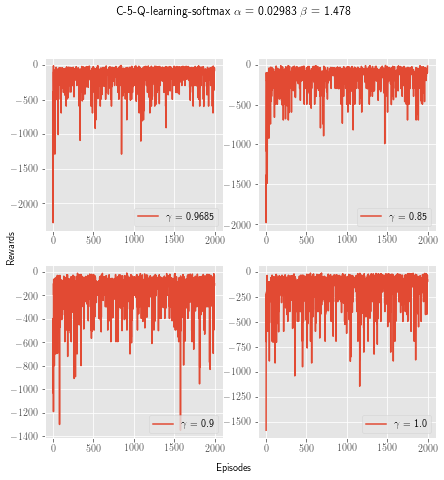

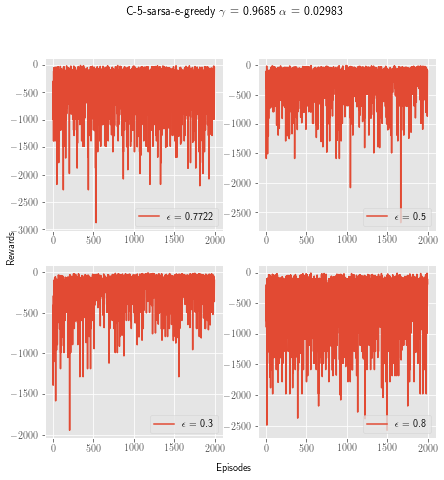

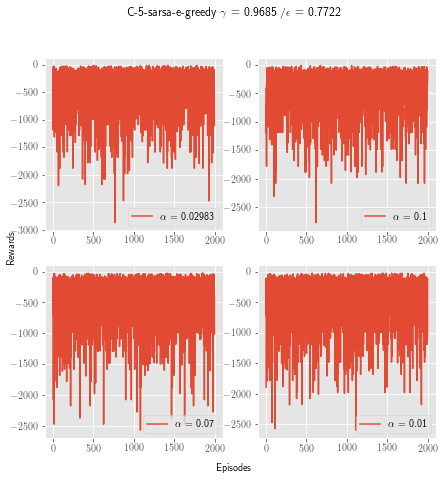

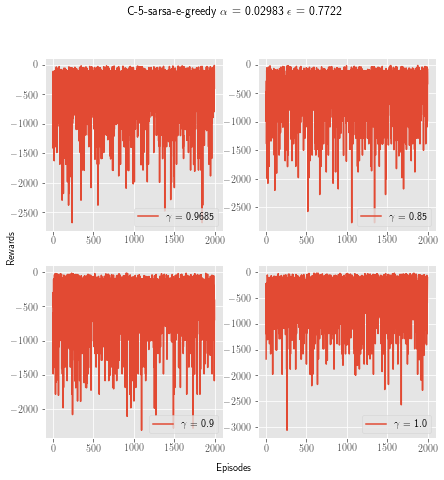

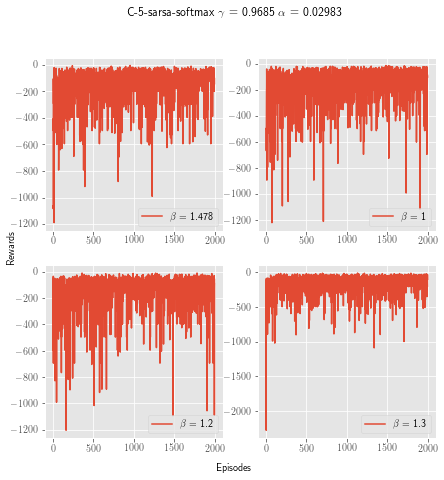

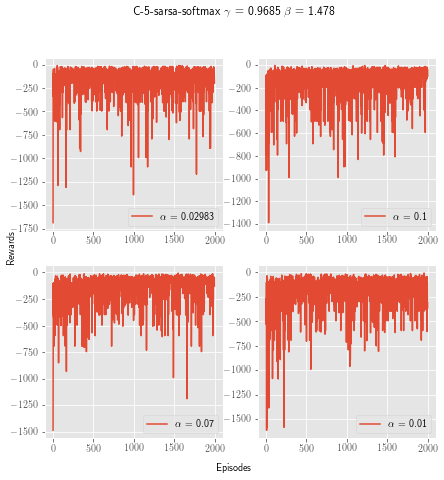

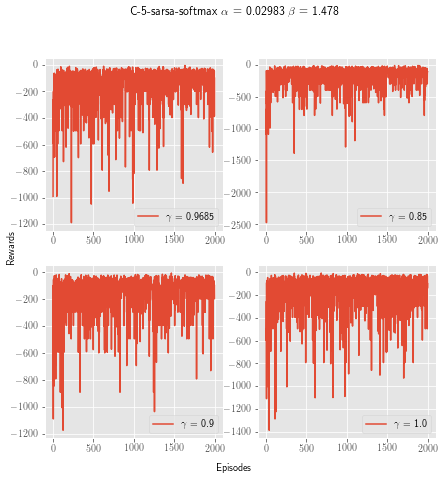

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

### best plots

In [ ]:
gamma = 0.85

100%|██████████| 2000/2000 [01:44<00:00, 19.08it/s]


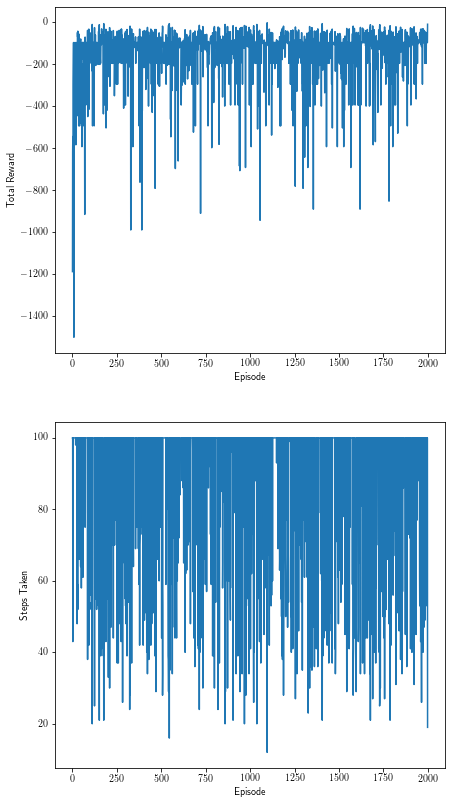

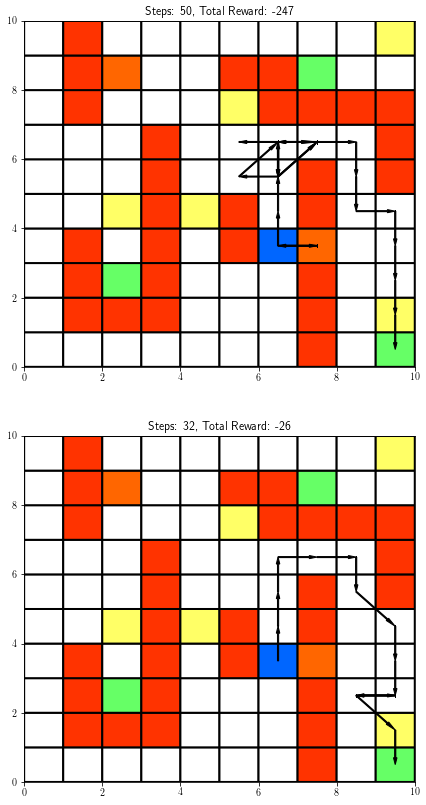

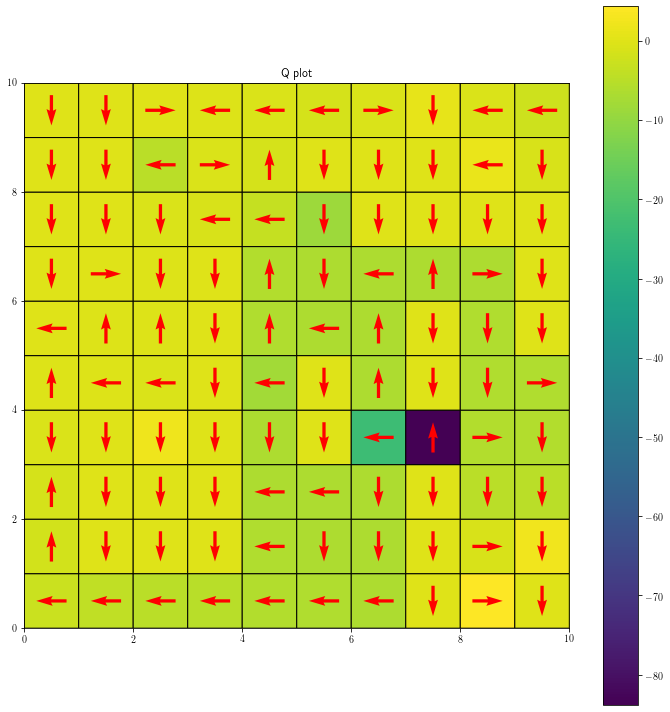

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## Config 6

In [ ]:
NUM_CONFIG = 6

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:
# swwep 19

alpha = 0.1170
l_alpha = [0.1, 0.12, 0.09]
beta = 0.883
l_beta = [1, 0.8, 0.9]
gamma = 0.9851
l_gamma = [0.85, 0.9, 1.0]
epsilon = 0.4062
l_epsilon = [0.5, 0.2, 0.3]
policy = 'softmax'
algorithm = 'q-learning'

In [ ]:
plt.style.use('seaborn')

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

### best plots

In [ ]:
algorithm = 'sarsa'

100%|██████████| 2000/2000 [00:21<00:00, 94.25it/s] 


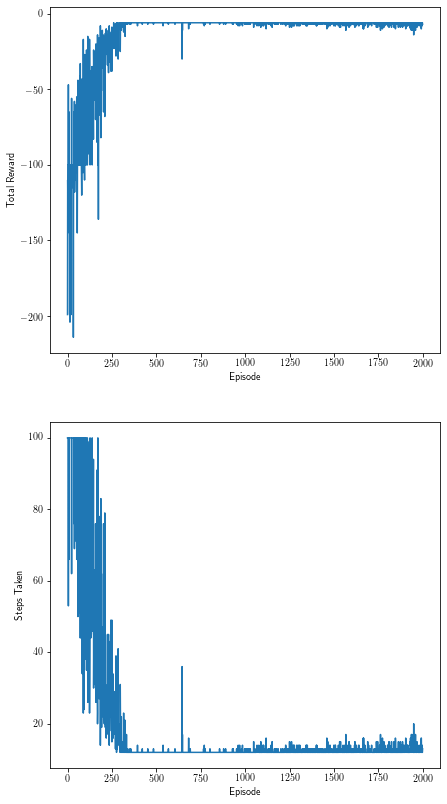

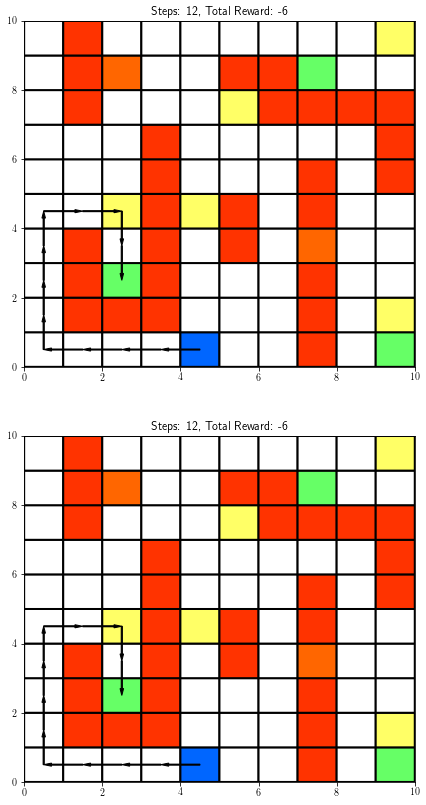

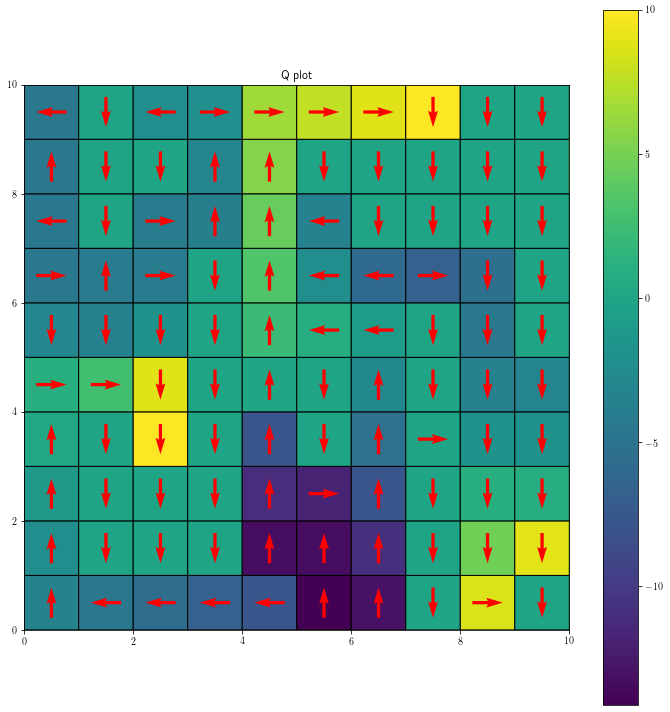

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## Config 7

In [ ]:
NUM_CONFIG = 7

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

Create sweep with ID: u6xuj3v1
Sweep URL: https://wandb.ai/sathvikjoel/RLPA1/sweeps/u6xuj3v1


In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:

alpha = 0.06673
l_alpha = [0.05, 0.1, 0.09]
beta = 1.306
l_beta = [1, 1.2, 1.1]
gamma = 0.9298
l_gamma = [0.90, 0.91, 1.0]
epsilon = 0.0993
l_epsilon = [0.1, 0.15, 0.05]
policy = 'e-greedy'
algorithm = 'sarsa'

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [00:15<00:00, 128.92it/s]


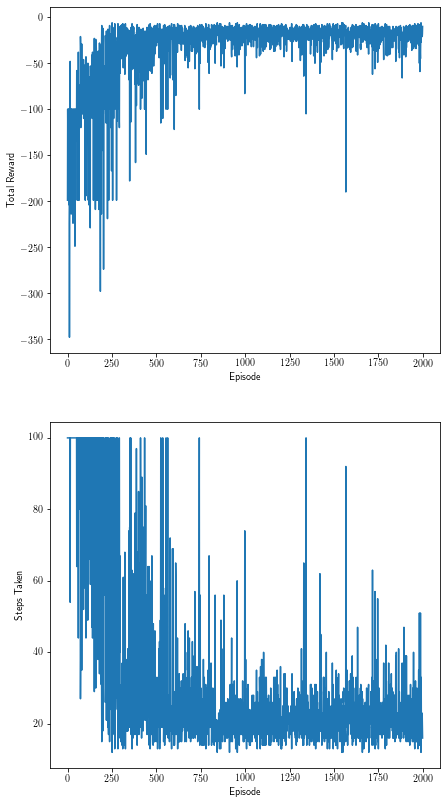

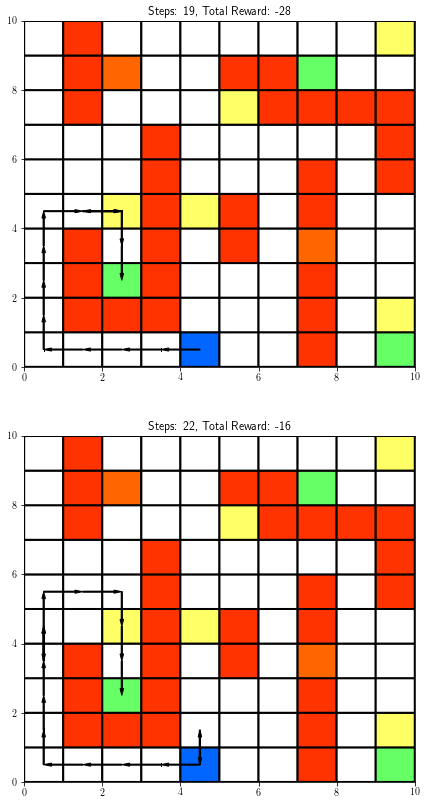

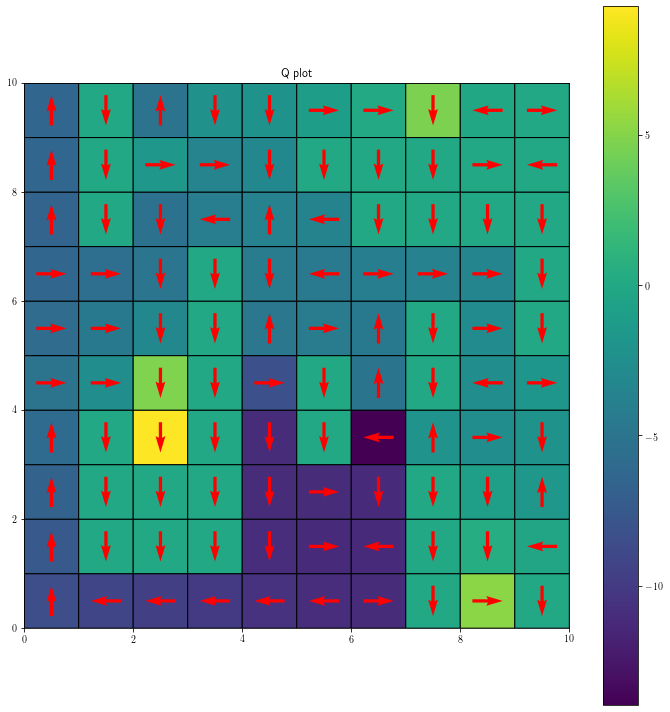

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## config 8

In [ ]:
NUM_CONFIG = 8

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

Create sweep with ID: api7o9ik
Sweep URL: https://wandb.ai/sathvikjoel/RLPA1/sweeps/api7o9ik


In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:

alpha = 0.09762
l_alpha = [0.05, 0.1, 0.09]
beta = 0.9012
l_beta = [1, 1.2, 1.1]
gamma = 0.9874
l_gamma = [0.90, 0.95, 1.0]
epsilon = 0.8899
l_epsilon = [0.80, 0.90, 0.85]
policy = 'e-greedy'
algorithm = 'q_learning'

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

100%|██████████| 2000/2000 [00:51<00:00, 38.80it/s]


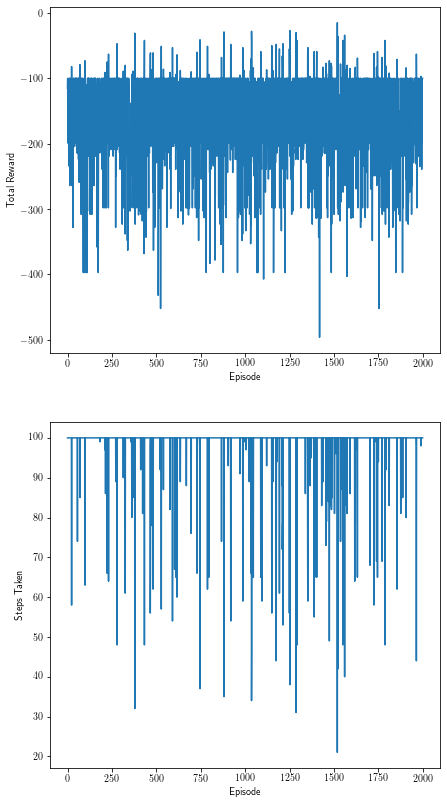

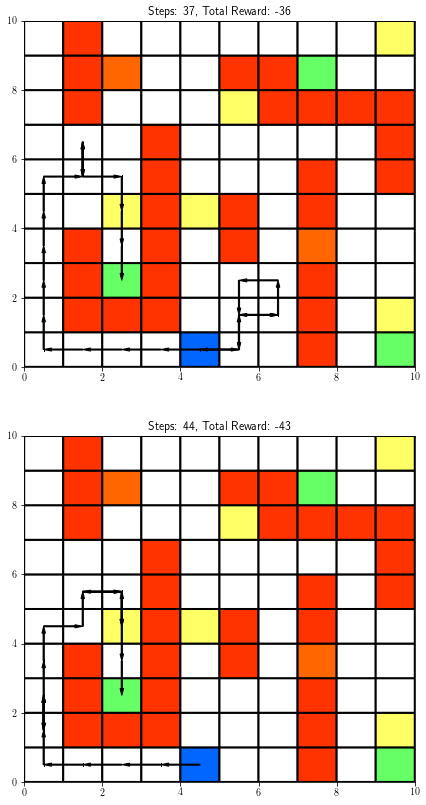

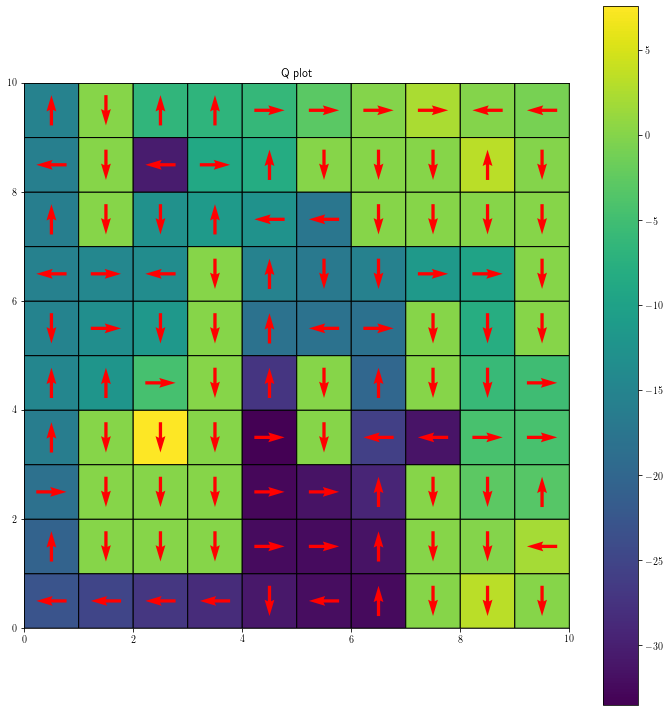

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

## config 11

In [ ]:
NUM_CONFIG = 11

config_settings = configurations_l[NUM_CONFIG]
    
# create environment
env = create_env(**config_settings._asdict())

sweep_config = {
    "name" : f"{NUM_CONFIG}-config-sweep",
    "method": "random",
    "parameters": {
        "algorithm": {
            "values": ['sarsa', 'q_learning'],
        },
        "policy": {
            "values": ['softmax', 'epsilon_greedy'],
        },
        "epsilon": {
            "min": 0.0,
            "max": 1.0,
        },
        "alpha": {
            "min": 0.01,
            "max": 0.2,
        },
        "gamma": {
            "min": 0.5,
            "max": 1.0,
        },
        "beta": {
            "min": 0.5,
            "max": 1.5,
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='RLPA1')

In [ ]:
wandb.agent(sweep_id, run, count=20)

### Plotting

In [ ]:

alpha = 0.1113
l_alpha = [0.08, 0.1, 0.09]
beta = 1.481
l_beta = [.55, 1.3, 1.1]
gamma = 0.9615
l_gamma = [0.90, 0.95, 1.0]
epsilon = 0.3098
l_epsilon = [0.45, 0.35, 0.40]
policy = 'e-greedy'
algorithm = 'q_learning'

100%|██████████| 2000/2000 [01:01<00:00, 32.40it/s]


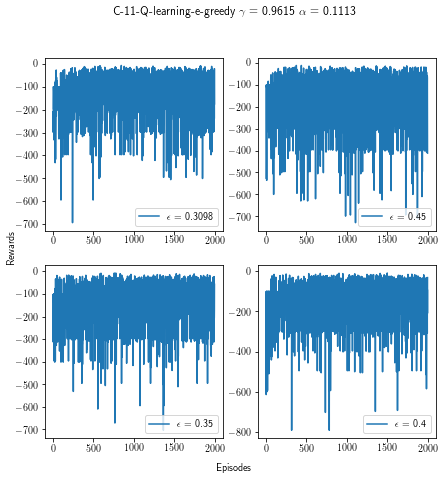

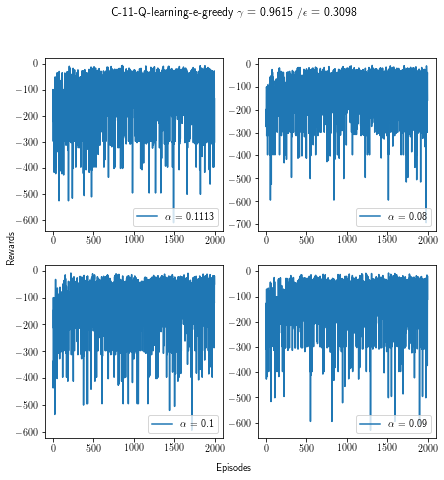

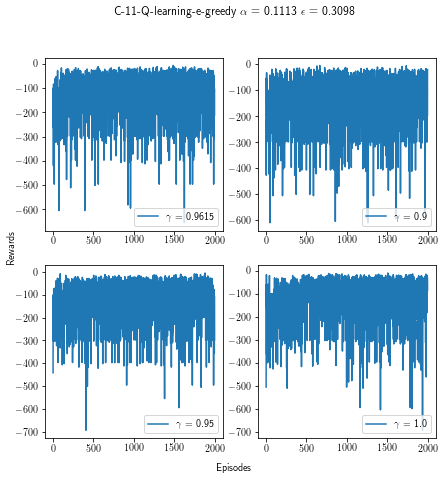

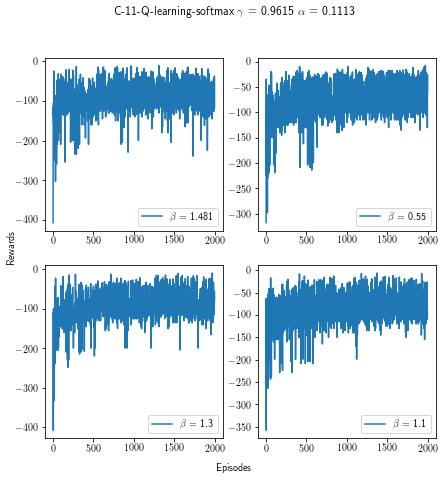

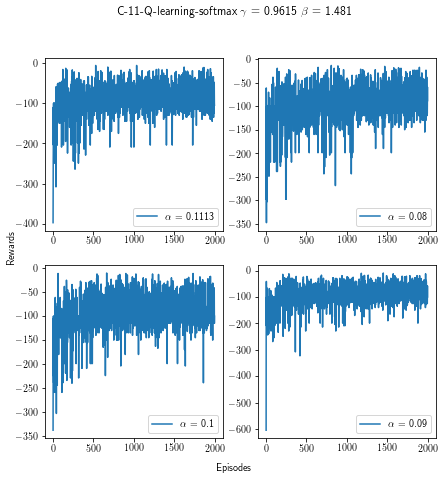

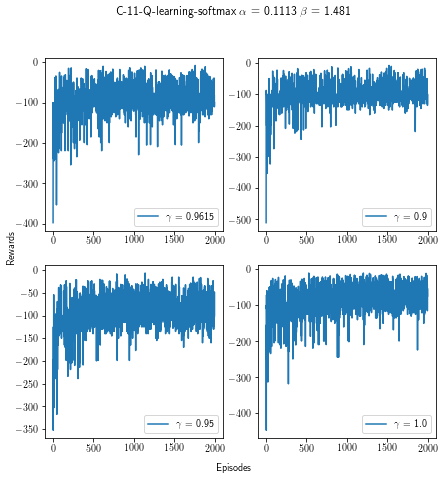

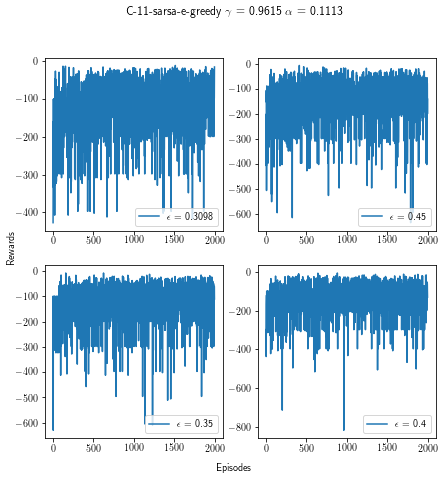

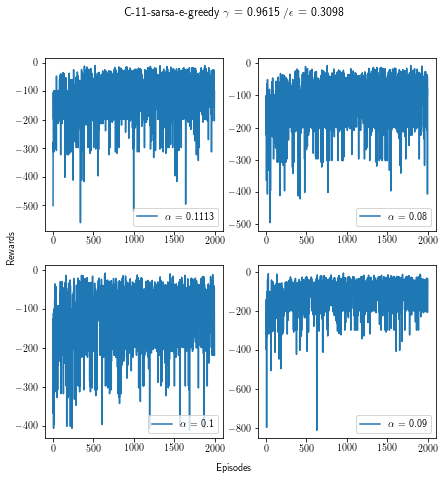

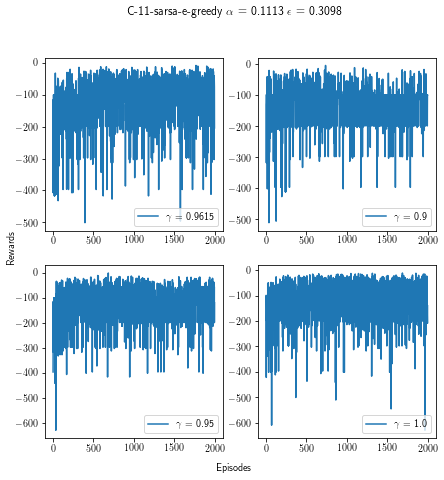

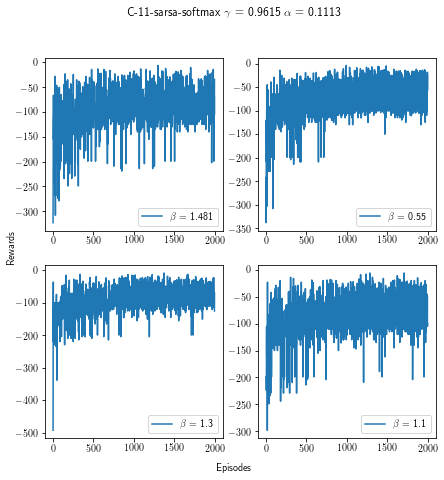

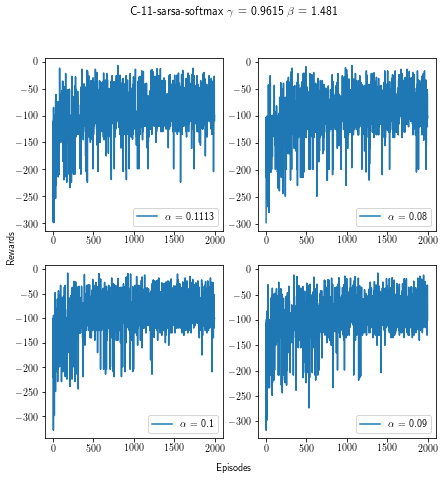

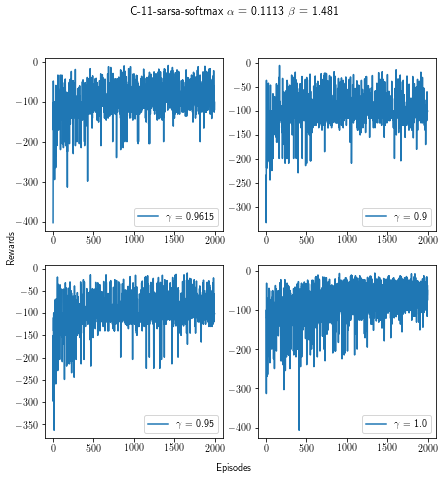

In [ ]:
plot_all(alpha, l_alpha, beta, l_beta, gamma, l_gamma, epsilon, l_epsilon)

In [ ]:
policy = 'softmax'

100%|██████████| 2000/2000 [01:43<00:00, 19.37it/s]


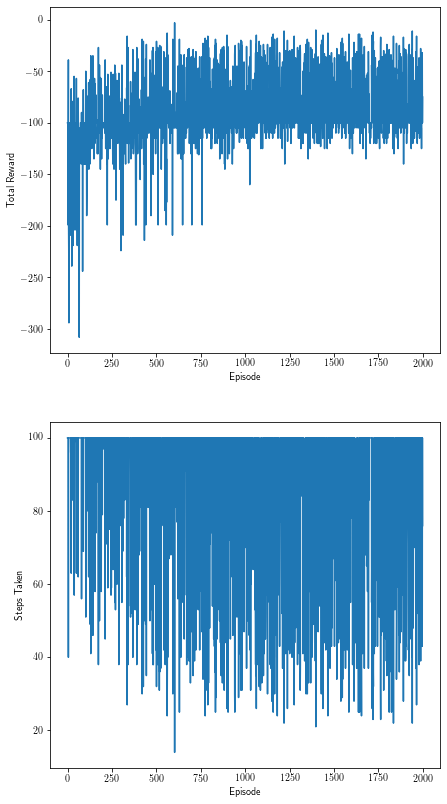

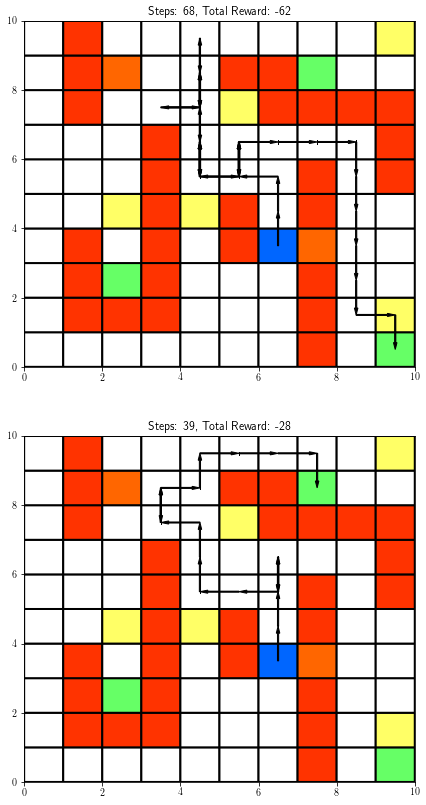

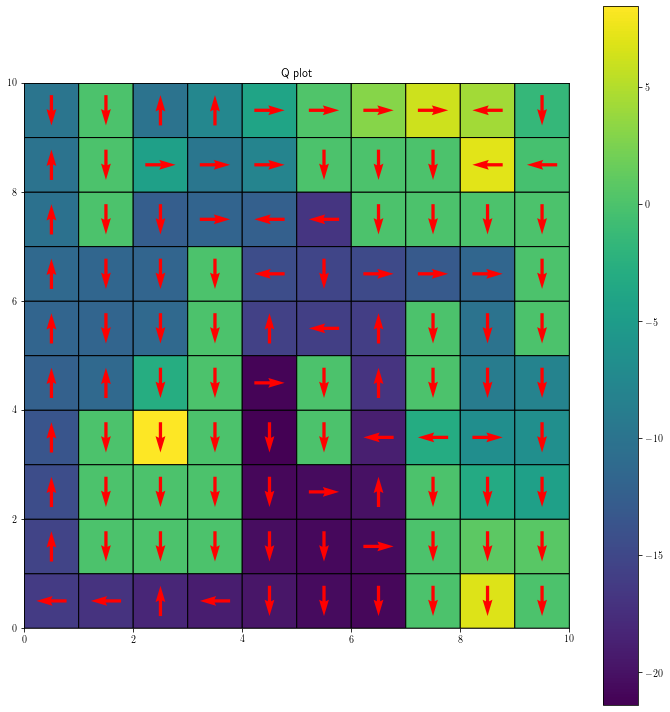

In [ ]:
Q = best_plots(algorithm, policy, alpha,  epsilon, beta , gamma )

# Code for downloading noteboook (IGNORE )

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-plain-generic is already the newest version (2017.20180305-2).
texlive-plain-generic set to manually installed.
The following NEW packages will be installed:
  texlive-xetex
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 21.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 texlive-xetex all 2017.20180305-1 [10.7 MB]
Fetched 10.7 MB in 15s (731 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a 

In [ ]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Documents/Sem6-drive/RL/Assignments/1Assignment/PA1_working_copy-1.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Documents/Sem6-drive/RL/Assignments/1Assignment/PA1_working_copy-1.ipynb to pdf
[NbConvertApp] Support files will be in PA1_working_copy-1_files/
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directory ./PA1_working_copy-1_files
[NbConvertApp] Making directo